# HOUSING PRICES: ADVANCED REGRESSION TECHNIQUES
#### *Team Project:  Craig Fleischman, plus 2 team members*

## 1. BUSINESS UNDERSTANDING
Predicting home prices similar to RedFin and Zillow leverage many attributes of a property. This competition contains 79 explanatory variables describing many details of residential homes in Ames, Iowa. The challenge is to predict the final price of each home.

Link to Kaggle Competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## 2.0 DATA Examination

### Importing Packages and loading data

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="darkgrid")
from scipy.stats import skew, norm
from scipy import stats
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn import linear_model
from sklearn.linear_model import ElasticNetCV, ElasticNet, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, classification_report
from math import sqrt

from lightgbm import LGBMRegressor
import lightgbm as lgb

In [5]:
# importing the training and test datasets into pandas dataframe
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Exploratory Data Analysis/EDA

In [6]:
# NOTE:  Training dataset has an extra column:  SalesPrice
print("\nTraining Size:", train.shape, "\nTesting Size:", test.shape)


Training Size: (1460, 81) 
Testing Size: (1459, 80)


There are 81 features in the training dataset provided by Kaggle, including the target variable (SalesPrice) and 1,460 observations. The testing dataset contains 80 features (excluding SalesPrice) and 1,459 observations. The analysis unit are residential homes sold in Ames, Iowa.

**SalesPrice** is the target variable that will be predicted and represents the property's sales price in US dollars. The SalesPrice has a positive skewed distribution and a log-transformation was applied to achieve a model fit improvement. See histogram analysis below for before and after transformation application.

The dataset includes 38 numeric and 43 categorical variables. The numerical variables were adjusted as follows:
- skewness (positively or negatively) were adjusted using BoxCox
- standardization 
- variables that were typed as numerical, but were really Categorical (MSSubClass)

Categorical variables:  
- Dummy variables were used

Both variables (Numerical and Categorical):
- feature engineering
- missing data
- outliers

The identifier variable (Id) is unique for each observation and will not be used as an explanatory variable.

Pandas-profiling package (https://github.com/pandas-profiling/pandas-profiling) was used to generate a detailed report that describes the dataset to highlight any anomalies, this included:
- Essentials: type, unique values, missing values
- Quantile statistics like minimum value, Q1, median, Q3, maximum, range, interquartile range
- Descriptive statistics like mean, mode, standard deviation, sum, median absolute deviation, coefficient of variation, kurtosis, skewness
- Most frequent values
- Histogram
- Correlations highlighting of highly correlated variables, Spearman, Pearson and Kendall matrices
- Missing values matrix, count, heatmap and dendrogram of missing values


In [7]:
pandas_profiling.ProfileReport(train)

In [8]:
train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

           ...         WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count      ...        1460.000000  1460.000000    1460.000000  1460.000000   
mean       ...          94.244521    46.660274      21.954110     3.409589   
std        ...         125.338794    66.256028      61.119149    29.317331   
min        ...           0.000000     0.000000       0.000000     0.000000   
25%        ...           0.000000     0.000000       0.000000     0.000000   
50%        ...           0.000000    25.000000       0.000000     0.000000   
75%        ...         168.000000    68.000000       0.000000     0.000000   
max        ...         857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       MoSold       YrSold  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000   
mean     15.060959     2.758904     43.489041     6.321918  2007.815753   
std      55.757415    40.177307    496.123024     2.703626     1.328095   
min       0.000000     0.000000      0.000000     1.000000  2006.000000   
25%       0.000000     0.000000      0.000000     5.000000  2007.000000   
50%       0.000000     0.000000      0.000000     6.000000  2008.000000   
75%       0.000000     0.000000      0.000000     8.000000  2009.000000   
max     480.000000   738.000000  15500.000000    12.000000  2010.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000  

[8 rows x 38 columns]

In [9]:
# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Remove 'Id' column since it's not needed for prediction
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## 3.0 Simple Baseline Model

In [10]:
# Save train data for use with Baseline Model separately 
trainbl = train.copy()

# For baseline model calculations, add Total Square Footage & Price per SqFt
trainbl['total_sqft'] = trainbl['TotalBsmtSF'] + trainbl['1stFlrSF'] + trainbl['2ndFlrSF']
trainbl['price_per_sqft'] = trainbl['SalePrice']/trainbl['total_sqft']

# Split baseline training data into train baseline and dev baseline sets
trainbl_data, trainbl_labels = trainbl[:1100].drop(['SalePrice'], axis=1), trainbl[:1100].pop('SalePrice')
devbl_data, devbl_labels = trainbl[1100:].drop(['SalePrice'], axis=1), trainbl[1100:].pop('SalePrice')
print('Train_baseline data shape:', trainbl_data.shape, '\tTrain_baseline labels shape:', trainbl_labels.shape)
print('Dev_baseline data shape:', devbl_data.shape, '\tDev_baseline labels shape:', devbl_labels.shape)



Train_baseline data shape: (1100, 81) 	Train_baseline labels shape: (1100,)
Dev_baseline data shape: (360, 81) 	Dev_baseline labels shape: (360,)


In [11]:
# Simple baseline model (median price/sq ft of the neighborhood in the same sold year)
class Baseline:
    # Initialize an instance of the class
    def __init__(self):
        pass
       
    def fit(self, train_data):
        # Calculate and store new reference df with median price/sq ft by neighborhood by year
        self.df = train_data.groupby(['Neighborhood', 'YrSold'])['price_per_sqft'].median().reset_index() 
    
    # predict for each test example and return results
    def predict(self, test_data):
        results = []
        for i,item in test_data.iterrows():
            median_price_per_sqft = self.df.loc[(self.df['Neighborhood'] == item['Neighborhood']) & 
                                                (self.df['YrSold'] == item['YrSold'])].price_per_sqft
            if len(median_price_per_sqft) > 0:
                results.append(item['total_sqft'] * median_price_per_sqft.values[0])
            else:
                results.append(self.df.loc[(self.df['Neighborhood'] == item['Neighborhood'])].price_per_sqft.values[0].mean())
        return np.array(results)
    
#A few references utlized:
#https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-95.php
#https://pandas.pydata.org
#https://codereview.stackexchange.com/questions/204549/lookup-closest-value-in-pandas-dataframe

In [12]:
baseline = Baseline()
baseline.fit(trainbl_data)
y_pred_bl = baseline.predict(devbl_data)
true_labels_bl = devbl_labels.as_matrix()

#Prints R2, RMSE and RMSLE scores
print("Baseline Model")
print("=========================================")
print("  Baseline R2:  {:.3f}".format(r2_score(true_labels_bl, y_pred_bl)))
print("  Baseline RMSE: {:,.2f}".format(np.sqrt(mean_squared_error(true_labels_bl, y_pred_bl))))
print("  Baseline RMSLE: {:.3f}".format(np.sqrt(mean_squared_log_error(true_labels_bl,y_pred_bl))))

Baseline Model
  Baseline R2:  0.661
  Baseline RMSE: 45,983.03
  Baseline RMSLE: 0.608


## 4.0 Predicted Variable Analysis:  Sales Price

mu = 180,921
sigma = 79,415


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


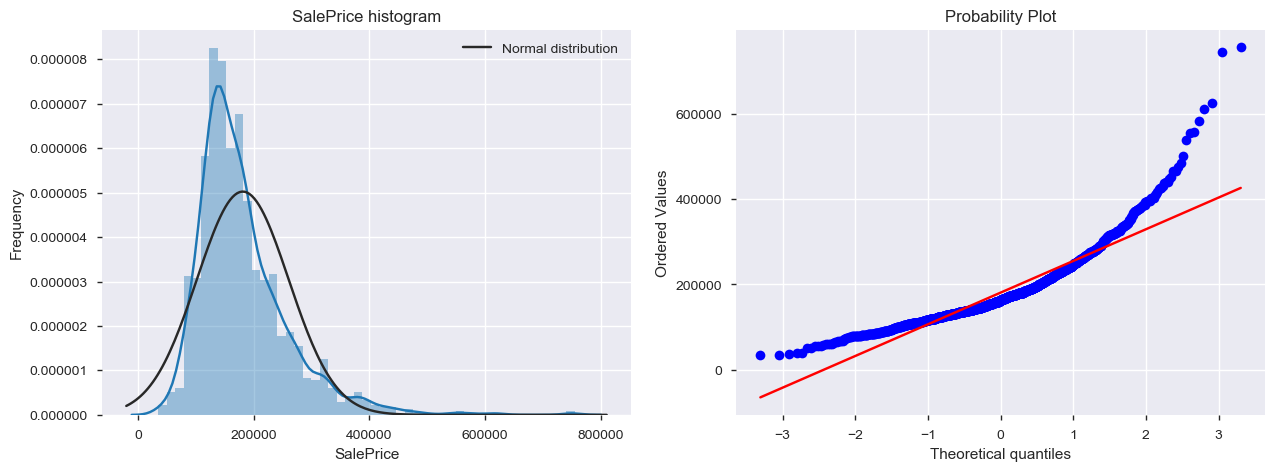

In [13]:
(mu, sigma) = norm.fit(train['SalePrice'])
print("mu = {:,.0f}".format(mu))
print("sigma = {:,.0f}".format(sigma))

# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm)

plt.legend(['Normal distribution'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice histogram')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The predicted variable is right skewed. The variable will be transformed to make it more normally distributed.
Log-transformation of the target variable

In [14]:
#Save the original SalePrice
train_SalesPrice_orig = train.SalePrice.values

# Apply transformation
# Log1p:  For real-valued input, log1p is accurate also for x so small that 1 + x == 1 in floating-point accuracy.
train["SalePrice"] = np.log1p(train["SalePrice"])

mu = 12.024
sigma = 0.399


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


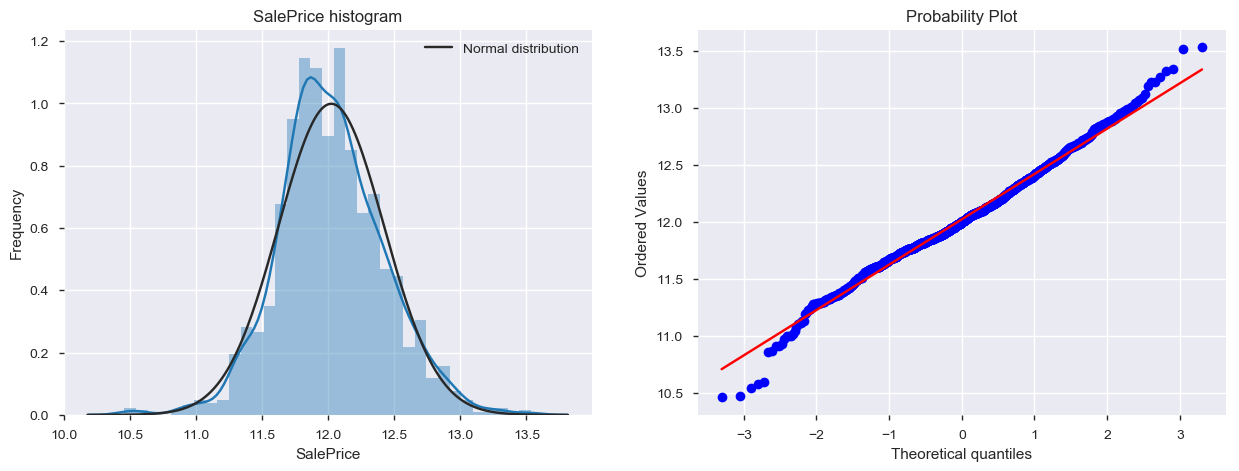

In [15]:
(mu, sigma) = norm.fit(train['SalePrice'])
print("mu = {:,.3f}".format(mu))
print("sigma = {:,.3f}".format(sigma))

# Plot histogram and probability
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train['SalePrice'] , fit=norm)

plt.legend(['Normal distribution'], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice histogram')
plt.subplot(1,2,2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## 5.0 Data Engineering

In [16]:
# get the original shape of training and test dataframes
train_shape = train.shape[0]
test_shape = test.shape[0]

# SalesPrice values post Logp1 Transform
train_labels_all = train.pop('SalePrice')

# Concatenate train and test datasets into one dataframe
all_data = pd.concat((train, test)).reset_index(drop=True)

# Review the size
print(all_data.shape)

(2919, 79)


In [17]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
pd.DataFrame({'% Missing' :all_data_na})

% Missing
PoolQC        99.657417
MiscFeature   96.402878
Alley         93.216855
Fence         80.438506
FireplaceQu   48.646797
LotFrontage   16.649538
GarageFinish   5.447071
GarageYrBlt    5.447071
GarageQual     5.447071
GarageCond     5.447071
GarageType     5.378554
BsmtExposure   2.809181
BsmtCond       2.809181
BsmtQual       2.774923
BsmtFinType2   2.740665
BsmtFinType1   2.706406
MasVnrType     0.822199
MasVnrArea     0.787941
MSZoning       0.137033
BsmtFullBath   0.068517
BsmtHalfBath   0.068517
Utilities      0.068517
Functional     0.068517
Exterior2nd    0.034258
Exterior1st    0.034258
SaleType       0.034258
BsmtFinSF1     0.034258
BsmtFinSF2     0.034258
BsmtUnfSF      0.034258
Electrical     0.034258
KitchenQual    0.034258
GarageCars     0.034258
GarageArea     0.034258
TotalBsmtSF    0.034258

#### Resolve Missing Data

In [18]:
# Replacing missing data with None
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC"
           ,'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    all_data[col] = all_data[col].fillna('None')

In [19]:
# Substitute in the most common string
common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for var in common_vars:
    all_data[var] = all_data[var].fillna(all_data[var].mode()[0])

In [20]:
# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [21]:
# Replacing missing data with 0
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2'
           ,'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
    all_data[col] = all_data[col].fillna(0)

In [22]:
# LotFrontage: fill in missing value by using the median LotFrontage in that specific neighborhood
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [23]:
# Functional NA means 'typical'
all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [24]:
# Changing to a categorical features since the distance between two categories are irrelevant
str_vars = ['MSSubClass']
for var in str_vars:
    all_data[var] = all_data[var].apply(str)

In [25]:
# Check that all the missing issues are resolved
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

Total  Percent
SaleCondition      0      0.0
Foundation         0      0.0
RoofMatl           0      0.0
Exterior1st        0      0.0
Exterior2nd        0      0.0

#### Feature Additions

In [26]:
# Adding total sq.ft. feature 
print("before:", all_data.shape)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
#  Adding total bathrooms feature 
all_data['Total_bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))
#  Adding total porch sqfootage feature
all_data['Total_porch_sqf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

#Remove columns that built the new feature
all_data.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)
all_data.drop(['FullBath', 'HalfBath', 'BsmtFullBath','BsmtHalfBath'], axis=1, inplace=True)
all_data.drop(['OpenPorchSF', '3SsnPorch', 'EnclosedPorch','ScreenPorch','WoodDeckSF'], axis=1, inplace=True)

before: (2919, 79)


In [27]:
print("after: ", all_data.shape)

after:  (2919, 70)


#### Numerical and Categorial features

Identifying Numerical features to perform standardization and Categorial features for LabelEncoding

In [28]:
# Differentiate numerical features and categorical features
numerical_features = all_data.dtypes[all_data.dtypes != "object"].index
print(numerical_features)

categorical_features = all_data.select_dtypes(include=['object']).columns
print(categorical_features)

print("Numerical features : {}".format(str(len(numerical_features))))
print("Categorical features : {}".format(str(len(categorical_features))))

feat_num = all_data[numerical_features]
feat_cat = all_data[categorical_features]

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'TotalSF', 'Total_bathrooms',
       'Total_porch_sqf'],
      dtype='object')
Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond

#### Transform Numerical Skewed data

The Box Cox transform technique (https://en.wikipedia.org/wiki/Power_transform) will be used to stabilize variance to make the data more normally distributed.

In it's simplest form a Box-Cox transformation of $x$ to $y$ is given by
$$
  y = \left.
  \begin{cases}
    \displaystyle\frac{x^\lambda - 1}{\lambda}, & \text{for } \lambda \neq 0, \\
    \ln (x), & \text{for } \lambda = 0. \\
  \end{cases}
  \right.
$$
The inverse of this transformation is
$$
  x = \left.
  \begin{cases}
    \displaystyle(\lambda y + 1)^{1 / \lambda}, & \text{for } \lambda \neq 0, \\
    \exp(y), & \text{for } \lambda = 0. \\
  \end{cases}
  \right.
$$

In [29]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

Skew
MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
MasVnrArea        2.613592
TotalSF           1.511479
LotFrontage       1.505704
BsmtFinSF1        1.425230
Total_porch_sqf   1.376649
GrLivArea         1.269358
BsmtUnfSF         0.919339
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
OverallCond       0.570312
Total_bathrooms   0.492247
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
MoSold            0.195884
YrSold            0.132399
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205

In [30]:
# all features with a skewness > +/- 0.75 will be transformed using Box Cox

skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
# The Lambda value indicates the power to which all data should be raised
lam = 0.15
for feat in skewed_features:
    all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 15 skewed numerical features to Box Cox transform


In [31]:
# Check the skew of all numerical features after transform applicagtion
skewed_feats = all_data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
print("Skew after Box Cox transform applied:")
skewness

Skew after Box Cox transform applied:


Skew
PoolArea         15.152901
LowQualFinSF      8.803572
MiscVal           5.674027
KitchenAbvGr      3.967148
BsmtFinSF2        2.594885
Fireplaces        0.733495
MasVnrArea        0.670364
OverallCond       0.570312
Total_bathrooms   0.492247
BedroomAbvGr      0.326324
GarageArea        0.239257
TotRmsAbvGrd      0.215758
LotArea           0.210943
OverallQual       0.197110
MoSold            0.195884
GrLivArea         0.175976
YrSold            0.132399
TotalSF          -0.125797
GarageCars       -0.219581
YearRemodAdd     -0.451020
BsmtFinSF1       -0.455079
YearBuilt        -0.599806
LotFrontage      -0.709090
Total_porch_sqf  -0.963762
BsmtUnfSF        -1.414917
GarageYrBlt      -3.925235

#### Creating Dummy Categorical Features

In [32]:
# Turning all Category features into dummy variables (0, 1)
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 309)


#### Correlations

In [98]:
# Highest Correlation with SalePrice (Absolute Value)
# Created a new DF just for Correlation
train_corr = all_data.copy()
train_corr['SalePrice'] = train_labels_all 
print("Highest correlated features:\n", train_corr.corr()['SalePrice'].abs().sort_values(ascending=False).head(10),
      "\n\nLowest correlated features:\n", train_corr.corr()['SalePrice'].abs().sort_values(ascending=True).head(10))

Highest correlated features:
 SalePrice          1.000000
OverallQual        0.817185
TotalSF            0.809310
GrLivArea          0.729338
GarageCars         0.680625
Total_bathrooms    0.673011
GarageArea         0.650888
ExterQual_TA       0.595882
YearBuilt          0.586570
YearRemodAdd       0.565608
Name: SalePrice, dtype: float64 

Lowest correlated features:
 MSSubClass_80        0.001134
MiscFeature_Gar2     0.001624
BsmtFinType2_GLQ     0.002345
RoofMatl_ClyTile     0.002696
SaleType_ConLI       0.003058
LotConfig_Corner     0.003985
LotConfig_FR2        0.004883
RoofMatl_Metal       0.005026
GarageCond_Gd        0.005239
RoofStyle_Mansard    0.005801
Name: SalePrice, dtype: float64


## 6.0 Modeling

Separating the training and test data and since the training data only contains labels, the training data is separated out again into 2 sets: train and dev

In [34]:
# reset index
all_data = all_data.reset_index()

# Split back out the training and test datasets
train_orig = all_data[:train_shape]
test_orig = all_data[train_shape:]
print("training data:  {}\ntraining labels: {}\ntesting data:   {}"
      .format(train_orig.shape, len(train_labels_all), test_orig.shape))

training data:  (1460, 310)
training labels: 1460
testing data:   (1459, 310)


In [35]:
# Creating train and dev from Original Training data (the only set with labels)
train = train_orig[:1100]
dev = train_orig[1100:]
train_labels = train_labels_all[:1100]
dev_labels = train_labels_all[1100:]
print("train:  {}\ntrain labels: {}\ndev:   {}\ndev labels: {}"
      .format(train.shape, len(train_labels), dev.shape, len(dev_labels))) 

train:  (1100, 310)
train labels: 1100
dev:   (360, 310)
dev labels: 360


In [36]:
# Define error metrics & Scores dictionary
def rmse(y_true, y_pred):
    # Mean squared error regression loss
    rmse = sqrt(mean_squared_error(np.expm1(y_true), np.expm1(y_pred)))
    return(rmse)

def rmsle(y_true, y_pred):
    # Mean squared logarithmic error regression loss
    rmsle = sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
    return(rmsle)

def r2(y_true, y_pred):
    # R^2 (coefficient of determination) regression score function.
    r2 = r2_score(np.expm1(y_true), np.expm1(y_pred))
    return(r2)

result_scores = {}
total_predictions = 0
Total_pred_train = 0
total_pred_count = 0

In [37]:
# Plot predictions
def plot_it(y_train, y_dev, model_title):
    plt.scatter(y_train, train_labels, c = "blue", alpha=0.6, marker = "o", label = "Training data")
    plt.scatter(y_dev, dev_labels, c = "green", alpha=0.6, marker = "o", label = "Validation data")
    plt.title(model_title)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

In [38]:
# Plot residuals
def plot_residuals(y_pred_train, y_pred, model_title):
    plt.scatter(y_pred_train, y_pred_train - train_labels, c = "blue", alpha=0.6, marker = "o", label = "Training data")
    plt.scatter(y_pred, y_pred - dev_labels, c = "green", alpha=0.6, marker = "o", label = "Validation data")
    plt.title(model_title)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()

In [39]:
# Plot feature importance
def plot_feat_import(coef, model_title):
    feature_coef = pd.Series(index=train.columns, data=coef)
    print('{} model picked {} out of {} features'.format(model_title, str(sum(feature_coef != 0)), str(train.shape[1])))
    top_bottom_10 = pd.concat([feature_coef.sort_values().head(10), feature_coef.sort_values().tail(10)])
    top_bottom_10.plot(kind='barh', title='Feature importance (Top and bottom 10) - {} model'.format(model_title))

### 6.1 Linear Regression

We started with a simple linear regression model as a baseline for our machine learning models. We tested 2nd degree polynomials and PCA dimentionality reduction for model improvements. Improvements from a combination of robust scaling and PCA reduction of components to n=50.

Linear Regression Model
r2	0.514
RMSE	55076.415
RMSLE	0.154


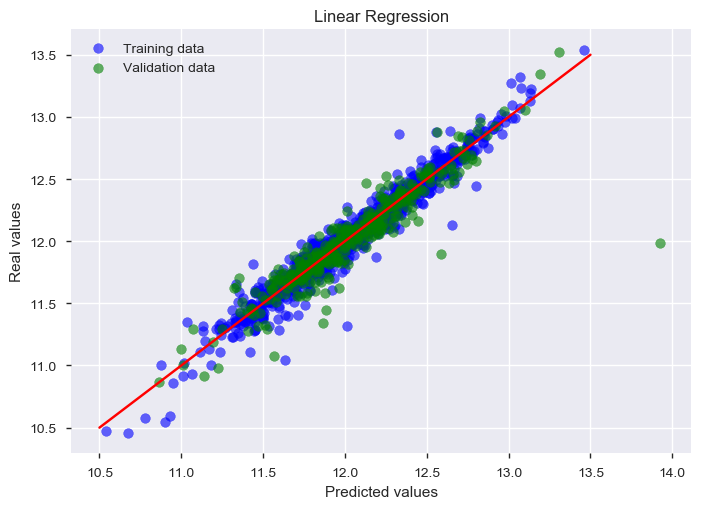

In [40]:
# simple linear regression model (ML baseline model)
lr = LinearRegression()
lr.fit(train, train_labels)

# predict
y_pred = lr.predict(dev)
y_pred_train = lr.predict(train)
total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1

# eval
score = rmsle(dev_labels, y_pred)
result_scores['LinReg'] = (score)

print("Linear Regression Model")
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'Linear Regression')

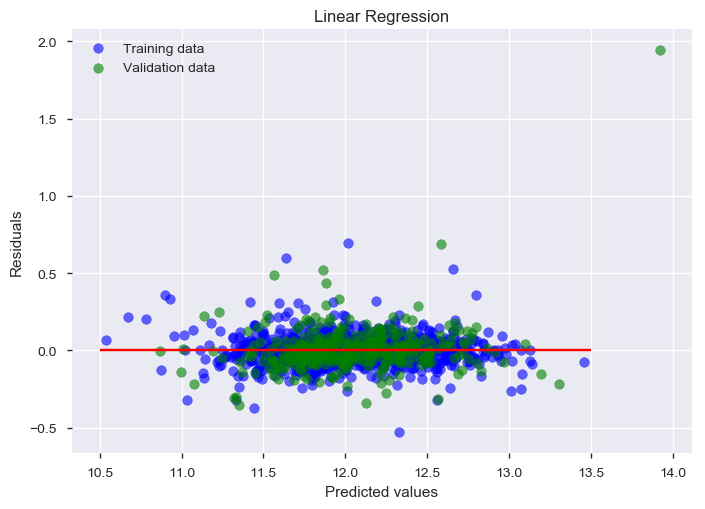

In [41]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "Linear Regression")

Linear Regression model picked 308 out of 310 features


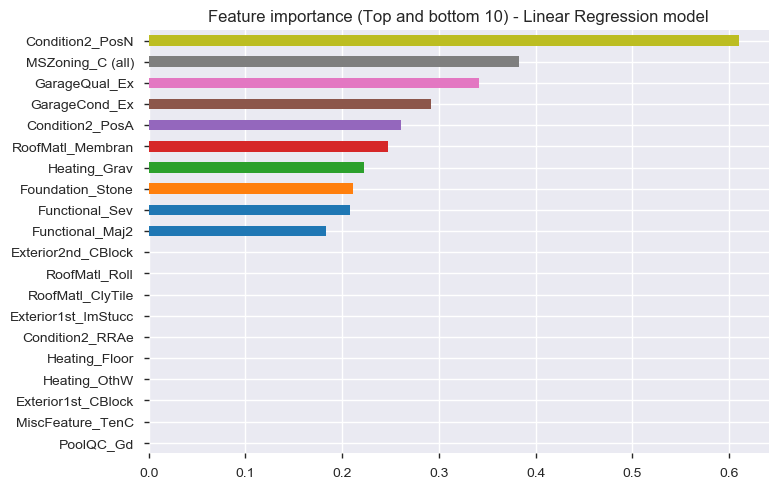

In [42]:
# Feature importance
plot_feat_import(np.abs(lr.coef_), "Linear Regression")

Linear Regression Model w/ Polynomial Features (degree=2)
r2	-15.945
RMSE	325187.033
RMSLE	0.680


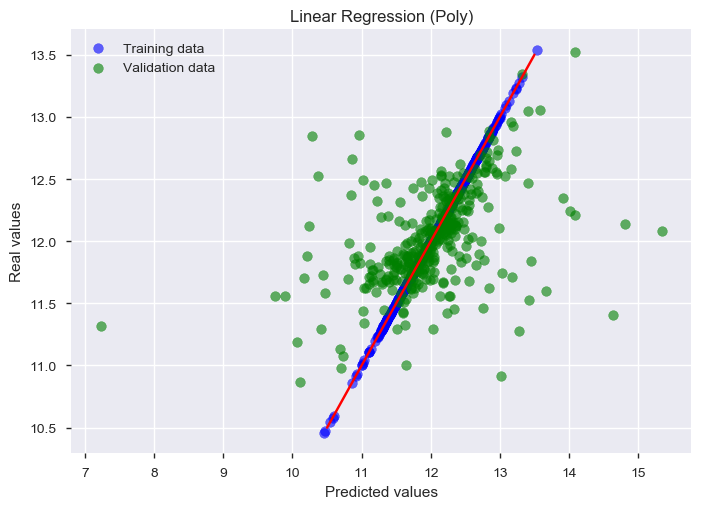

In [43]:
# Adding 2nd degree Polynomial Features did not improve model performance
model = make_pipeline(PolynomialFeatures(degree=2),
                     LinearRegression())
model.fit(train, train_labels)

# predict
y_pred = model.predict(dev)
y_pred_train = model.predict(train)
total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1

score = rmsle(dev_labels, y_pred)
result_scores['LinReg_Poly'] = (score)

print("Linear Regression Model w/ Polynomial Features (degree=2)")
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'Linear Regression (Poly)')

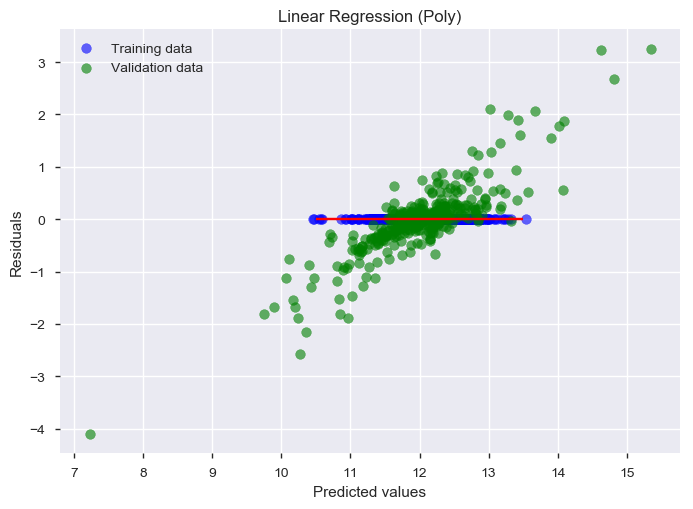

In [44]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "Linear Regression (Poly)")

Linear Regression Model w/ PCA {'pca__n_components': 50}
r2	0.625
RMSE	48382.050
RMSLE	0.150


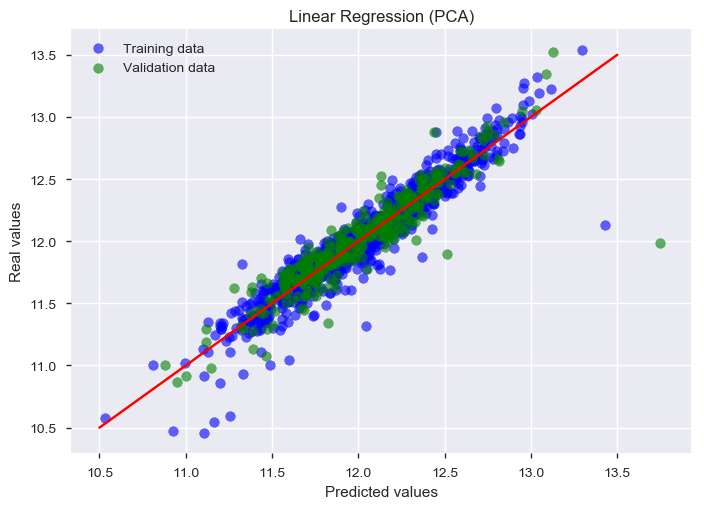

In [45]:
# Scaling and dimentionality reduction improved model performance
# search best PCA n_components with grid search
pipe = Pipeline(steps=[('scaler', RobustScaler()),('pca', PCA()), ('linear', LinearRegression())])
param_grid = {
    'pca__n_components': [5,20,30,40,50],
}
search = GridSearchCV(pipe, param_grid, cv=5)
search.fit(train, train_labels)
#print("Best parameter (CV score=%0.3f):" % search.best_score_)

# predict
y_pred = search.predict(dev)
y_pred_train = search.predict(train)
total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1

score = rmsle(dev_labels, y_pred)
result_scores['LinReg_PCA'] = (score)

# eval
print("Linear Regression Model w/ PCA %s" %search.best_params_)
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'Linear Regression (PCA)')

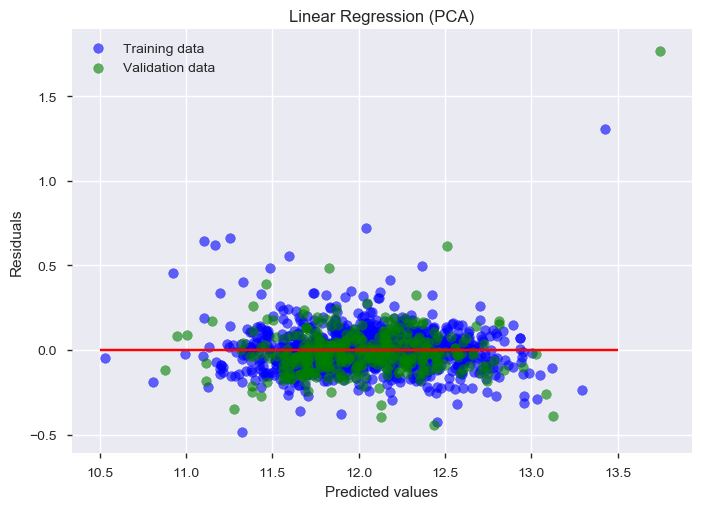

In [46]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "Linear Regression (PCA)")

### 6.2 Regularization - Lasso, Ridge, ElasticNet

Next, we applied regularization with Ridge, Lasso and ElasticNet estimators which improved model performance.

best alpha: 0.001
Lasso Model
r2	0.691
RMSE	43939.576
RMSLE	0.139


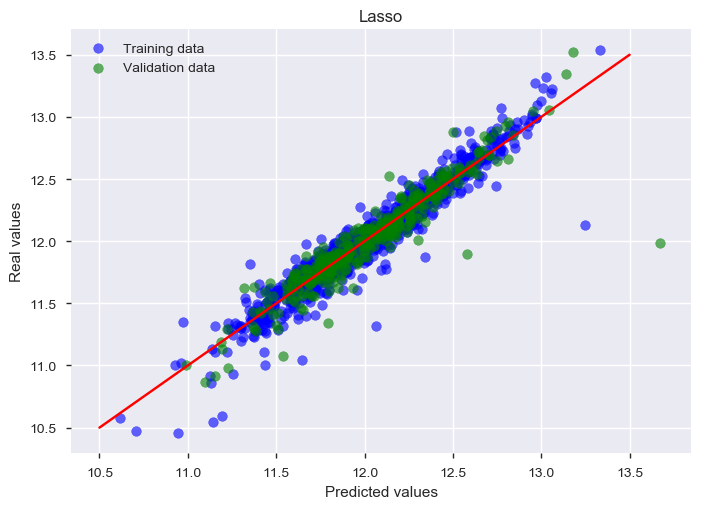

In [47]:
# LassoCV estimator to choose best alpha for Lasso model.
LassoTest = linear_model.LassoCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10])
LassoTest.fit(train, train_labels)
best_alpha = LassoTest.alpha_
print("best alpha: {}".format(best_alpha))

train_scaled = RobustScaler().fit_transform(train)
dev_scaled = RobustScaler().fit_transform(dev)
lasso = Lasso(alpha=best_alpha, random_state=3)
lasso.fit(train_scaled, train_labels)
y_pred = lasso.predict(dev_scaled)
y_pred_train = lasso.predict(train_scaled)
total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1

score = rmsle(dev_labels, y_pred)
result_scores['Lasso'] = (score)

# eval
print("Lasso Model")
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'Lasso')

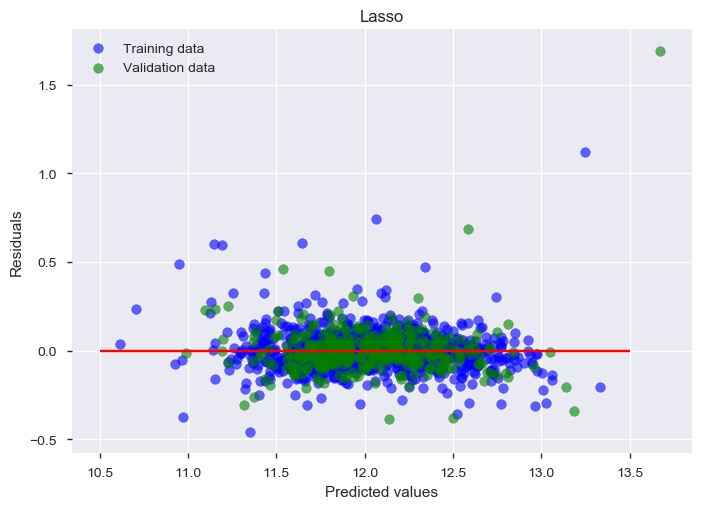

In [48]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "Lasso")

Lasso model picked 80 out of 310 features


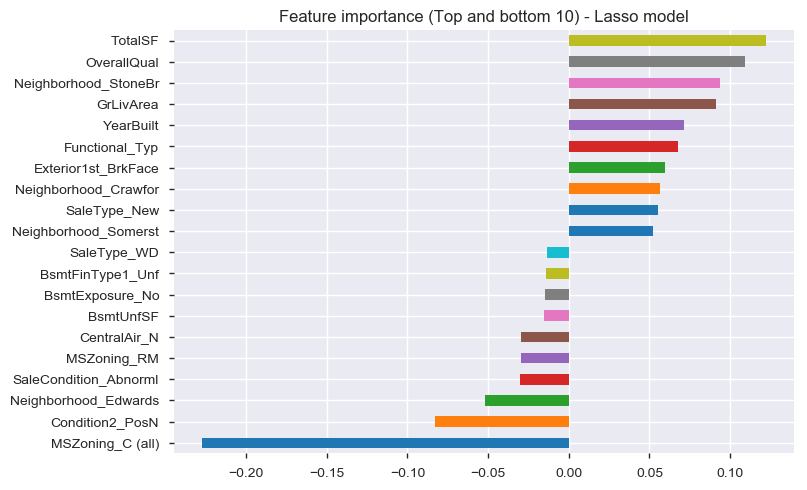

In [49]:
# Feature importance
plot_feat_import(lasso.coef_, "Lasso")

best alpha: 20.0
Ridge Model
r2	0.693
RMSE	43802.838
RMSLE	0.139


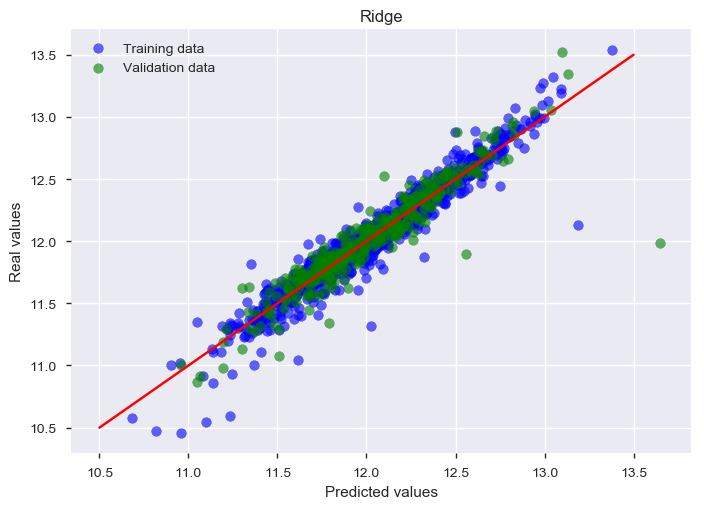

In [50]:
# RidgeCV estimator to choose best alpha for Ridge model.
RidgeTest = linear_model.RidgeCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10, 20, 30, 40])
RidgeTest.fit(train, train_labels)
best_alpha = RidgeTest.alpha_
print("best alpha: {}".format(best_alpha))

train_scaled = RobustScaler().fit_transform(train)
dev_scaled = RobustScaler().fit_transform(dev)
ridge = Ridge(alpha=best_alpha, random_state=3)
ridge.fit(train_scaled, train_labels)
y_pred = ridge.predict(dev_scaled)
y_pred_train = ridge.predict(train_scaled)
total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1

score = rmsle(dev_labels, y_pred)
result_scores['Ridge'] = (score)

# eval
print("Ridge Model")
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'Ridge')

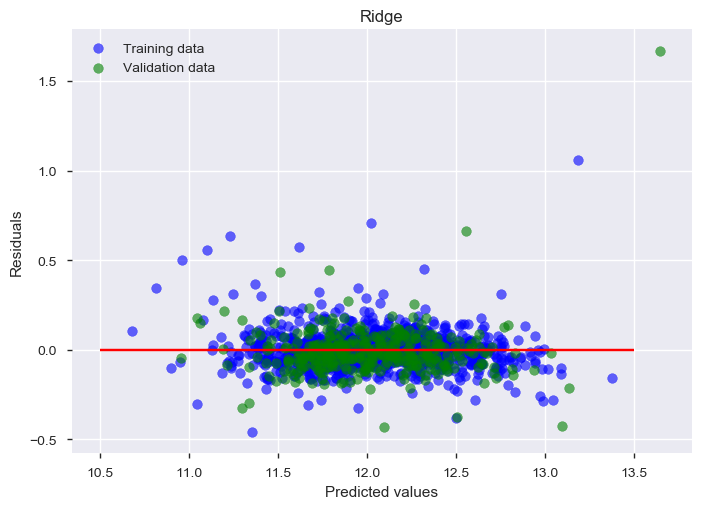

In [51]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "Ridge")

Ridge model picked 297 out of 310 features


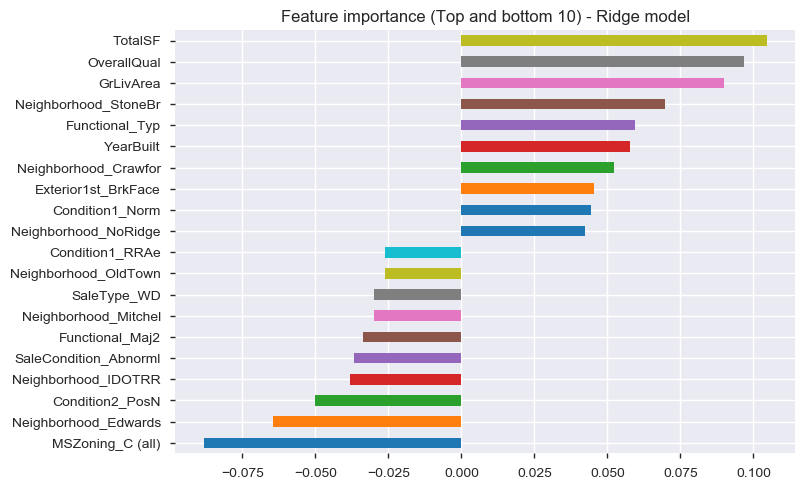

In [52]:
# Feature importance
plot_feat_import(ridge.coef_, "Ridge")

In [53]:
# ElasticNetCV estimator to choose best alpha and l1_ratio for Elastic Net model.
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], 
            l1_ratio=[.01, .1, .5, .6, .7, .8, .9, .99, .999], max_iter=20000)
ENSTest.fit(train, train_labels)
best_alpha = ENSTest.alpha_
best_l1 = ENSTest.l1_ratio_
print("best alpha: {}".format(best_alpha))
print("best L1: {}".format(best_l1))

best alpha: 0.001
best L1: 0.7


ElasticNet Model
r2	0.695
RMSE	43611.043
RMSLE	0.139


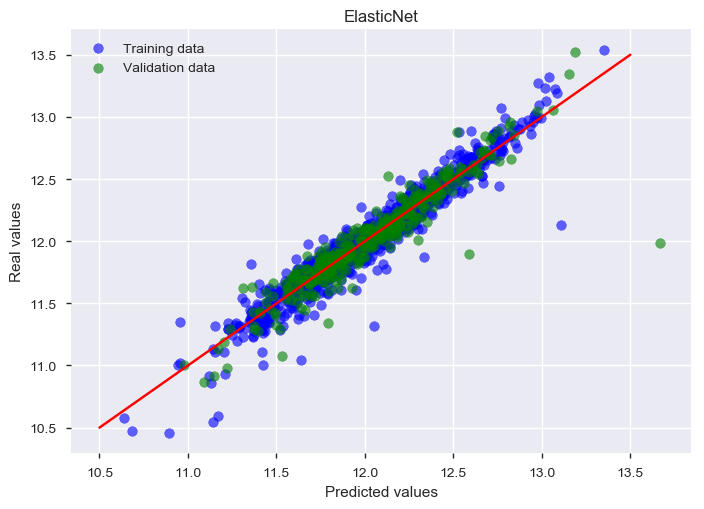

In [54]:
# Use best_alpha and L1 from above

#ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=5000, random_state=3))
train_scaled = RobustScaler().fit_transform(train)
dev_scaled = RobustScaler().fit_transform(dev)
ENet = ElasticNet(alpha=best_alpha, l1_ratio=best_l1, max_iter=5000, random_state=3)
ENet.fit(train_scaled, train_labels)
train_score = ENet.score(train_scaled, train_labels)
y_pred = ENet.predict(dev_scaled)
y_pred_train = ENet.predict(train_scaled)
total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1


score = rmsle(dev_labels, y_pred)
result_scores['ElasticNet'] = (score)

print("ElasticNet Model")
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'ElasticNet')

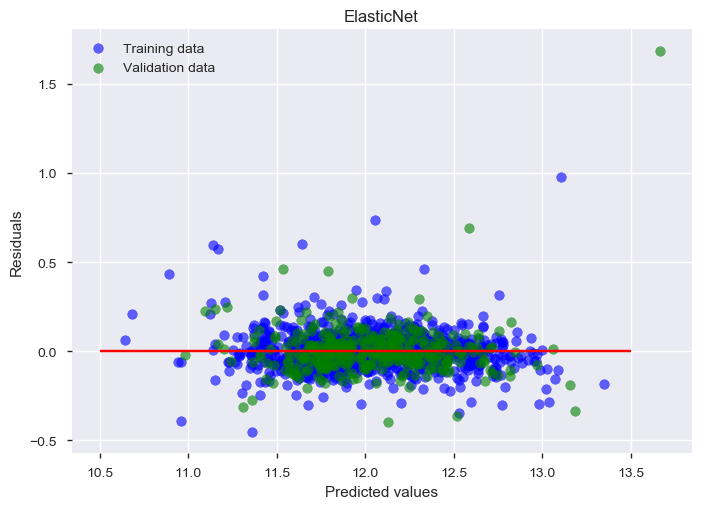

In [55]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "ElasticNet")

Elastic Net model picked 96 out of 310 features


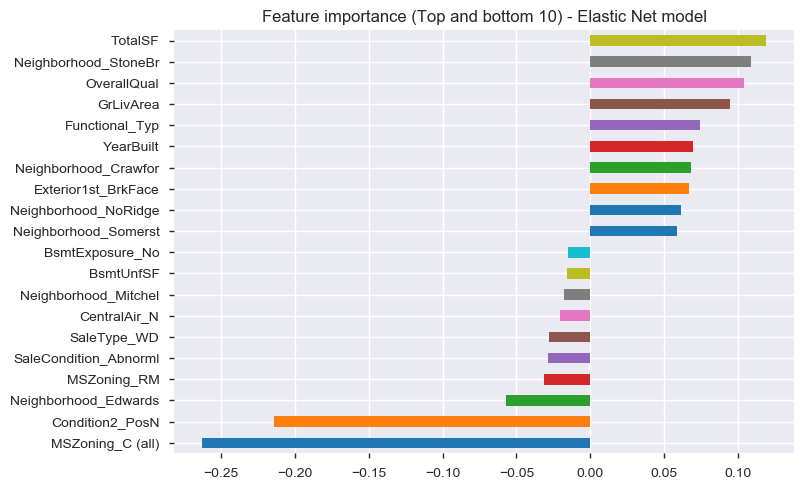

In [56]:
# Feature importance
plot_feat_import(ENet.coef_, "Elastic Net")

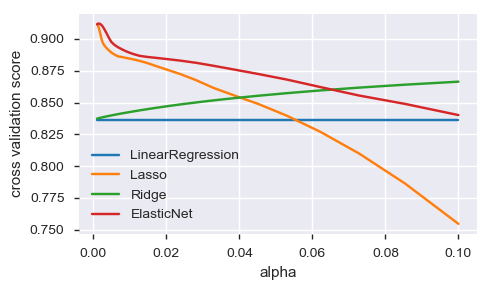

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

#for Model in [LinearRegression, Ridge, Lasso, ElasticNet]:
#    model = Model()
#    print('%s: %s' % (Model.__name__,
#                      cross_val_score(model, train, train_labels).mean()))
    
#alphas = [0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10]
alphas = np.logspace(-3, -1, 30)

plt.figure(figsize=(5, 3))

for Model in [LinearRegression, Lasso, Ridge, ElasticNet]:
    scores = [cross_val_score(Model(alpha), train, train_labels, cv=3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()

### 6.4 Light Gradient Boosting Regressor

LGB Model
r2	0.863
RMSE	29244.219
RMSLE	0.125


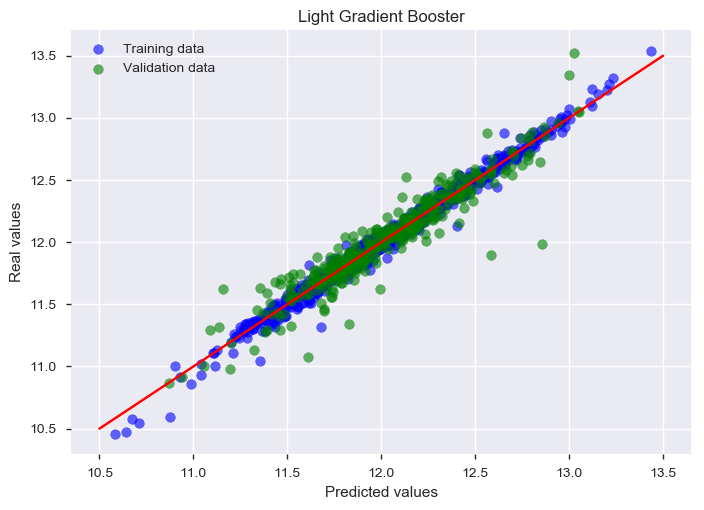

In [58]:
# train

gbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf=11,
                       verbose=-1,
                       random_state=42)

gbm.fit(train, train_labels, eval_metric='l1')

# predict
y_pred = gbm.predict(dev, num_iteration=gbm.best_iteration_)
y_pred_train = gbm.predict(train, num_iteration=gbm.best_iteration_)

total_predictions += y_pred
Total_pred_train += y_pred_train
total_pred_count +=1
score = rmsle(dev_labels, y_pred)
result_scores['L_Grad_Boost'] = (score)

# eval
print("LGB Model")
print("r2\t{:.3f}".format(r2(dev_labels, y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, y_pred)))
print("RMSLE\t{:.3f}".format(score))
plot_it(y_pred_train, y_pred, 'Light Gradient Booster')

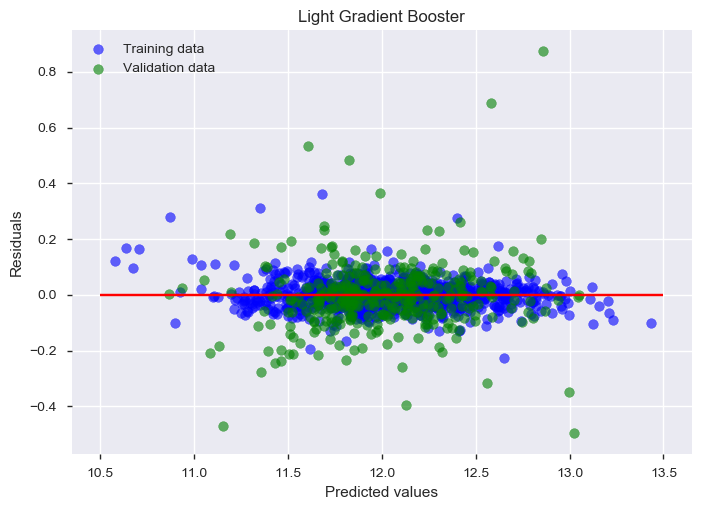

In [59]:
# Plot residuals
plot_residuals(y_pred_train, y_pred, "Light Gradient Booster")

Light Gradient Booster model picked 190 out of 310 features


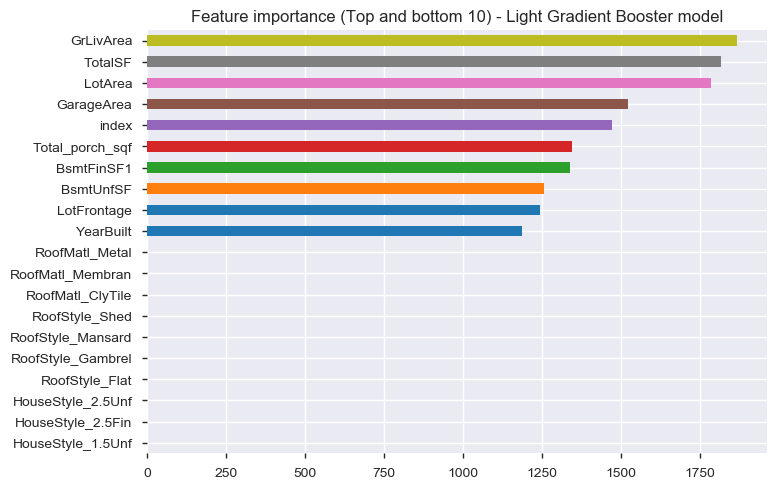

In [60]:
# Feature importance
plot_feat_import(gbm.feature_importances_, "Light Gradient Booster")

### 6.5 Neural Network Model

In [61]:
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout
from keras import optimizers


from sklearn.preprocessing import RobustScaler, MinMaxScaler, QuantileTransformer, StandardScaler, MaxAbsScaler
from sklearn.metrics import r2_score, mean_squared_error, classification_report 

Using TensorFlow backend.


#### 6.5.1 Data Transform and Build the NN

In [62]:
# transfer the data to a NN model
NN_train_data = train.copy(deep=True)
NN_train_labels = train_labels.copy(deep=True)
NN_dev_data = dev.copy(deep=True)
NN_dev_labels = dev_labels.copy(deep=True)

NN_train_sp = pd.read_csv('train.csv')
NN_train_labels = NN_train_sp[:1100].pop('SalePrice')



NN_train_data = NN_train_data.values
NN_dev_data = NN_dev_data.values
NN_train_labels = NN_train_labels.values
NN_dev_labels = NN_dev_labels.values

#Transform the data to scaler for all features
scaler = RobustScaler()
#QuantileTransformer = .42, MinMaxScaler, StandardScaler = .68, MaxAbsScaler= .41, RobustScaler= .67
NN_train_data = scaler.fit_transform(NN_train_data)
NN_dev_data = scaler.transform(NN_dev_data)
#print(NN_train_data
NN_train_data


array([[-1.        , -0.2564008 , -0.24729203, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99818016,  0.47038425,  0.04263192, ...,  0.        ,
         0.        ,  0.        ],
       [-0.99636033, -0.1006867 ,  0.41084436, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.99636033, -0.52961575, -1.99727724, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.99818016, -1.13757451, -0.99839153, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.55855393,  0.53937982, ...,  0.        ,
        -1.        ,  0.        ]])

In [63]:
#Build the NN Model
model = Sequential()
 
model.add(Dense(units=500 , input_dim= NN_train_data.shape[1], activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units=250 , activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units=125 , activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units=50 , activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units=25 , activation = 'relu'))
model.add(Dropout(.1))
model.add(Dense(units=1 , activation = 'linear'))

#Function to compile and fit the model
def NN_model_run(optimizer, loss, metrics, epochs, batch_size):
    model.compile(optimizer= optimizer, loss = loss , metrics = [metrics])
    model.fit(NN_train_data, NN_train_labels, shuffle = False, validation_split = .2, verbose = 0, batch_size = batch_size, epochs = epochs)
    y_pred = model.predict(NN_dev_data)
    y_pred_train = model.predict(NN_train_data)
    y_pred = np.log1p(y_pred)    
    y_pred_train = np.log1p(y_pred_train)
    return y_pred, y_pred_train
    



#### 6.6.2 Find Optimized Parameters for NN Model

# WARNING:  Long computation duration Required

    batch_size        r2          RMSE     RMSLE
0           10  0.697003  43484.656625  0.199809
1           20  0.669818  45393.530744  0.173335
2           30  0.701152  43185.931435  0.187045
3           40  0.654428  46439.360926  0.175862
4           50  0.638354  47507.165062  0.189024
5           60  0.686790  44211.463537  0.174201
6           70  0.695461  43595.211222  0.168140
7           80  0.702773  43068.638319  0.163098
8           90  0.710421  42510.959408  0.159280
9          100  0.677602  44855.240306  0.173592
10         200  0.667905  45524.805270  0.170289
11         300  0.735202  40651.320595  0.166072
12         500  0.724758  41445.235418  0.158703
13        1000  0.734541  40702.046856  0.157399
14        1500  0.737092  40506.003401  0.160388
15        2000  0.728725  41145.439308  0.156726
16        2500  0.733499  40781.777351  0.178923
17        2700  0.719702  41824.184679  0.159206
18        3000  0.739099  40351.038256  0.156237
19        3500  0.72

Text(0.5,0,'Batch Size')

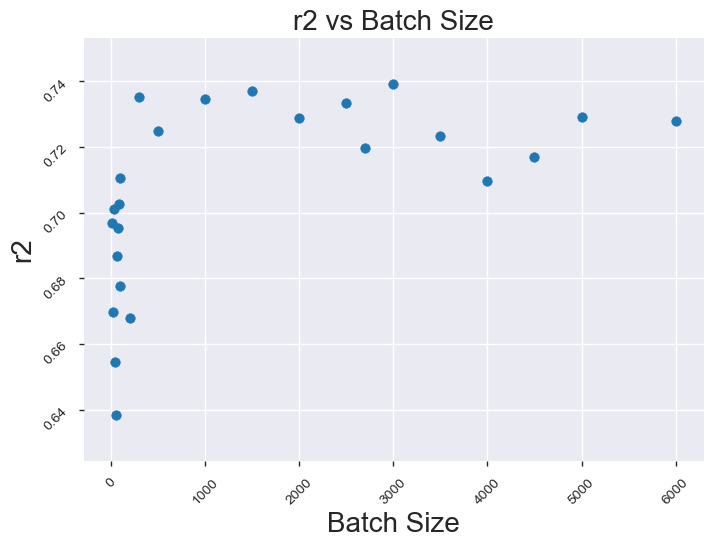

In [64]:
# Find the best batch_size
r2_list = []
rmse_list = []
rmsle_list = []
optimizer = 'nadam'
epochs = 32
batch_size = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500, 1000, 1500, 2000, 2500, 2700, 3000, 3500, 4000, 4500, 5000, 6000]
loss = 'mean_squared_error'
metrics = 'mean_squared_error'
for x in batch_size:
    y_pred = NN_model_run(optimizer, loss, metrics, epochs, x)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['batch_size','r2', 'RMSE', 'RMSLE'])
resultsdf['batch_size'] = batch_size
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['batch_size'] , y = resultsdf['r2'])
plt.title('r2 vs Batch Size', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('Batch Size', fontsize =20)


    epochs        r2          RMSE     RMSLE
0       10  0.725673  41376.304473  0.161416
1       20  0.724055  41498.145756  0.161065
2       30  0.725357  41400.082024  0.157833
3       40  0.721581  41683.743240  0.164766
4       50  0.731595  40927.241808  0.167056
5       60  0.740814  40218.235242  0.156845
6       70  0.757593  38894.612562  0.156774
7       80  0.748986  39579.094937  0.155509
8       90  0.757277  38920.000217  0.153840
9      100  0.757779  38879.690831  0.150769
10     200  0.750634  39448.986926  0.157558
11     300  0.749305  39553.989782  0.158869
12     500  0.750184  39484.549457  0.154163
13    1000  0.759752  38721.013650  0.153088
14    1500  0.756267  39000.841961  0.154818
15    2000  0.776324  37361.735813  0.153496
16    2500  0.776659  37333.711722  0.149150
17    3000  0.763179  38443.892495  0.154318
18    3500  0.773361  37608.334522  0.149338
19    4000  0.756950  38946.164209  0.153603
20    5000  0.749428  39544.285761  0.157898
21    6000

Text(0.5,0,'Epoch')

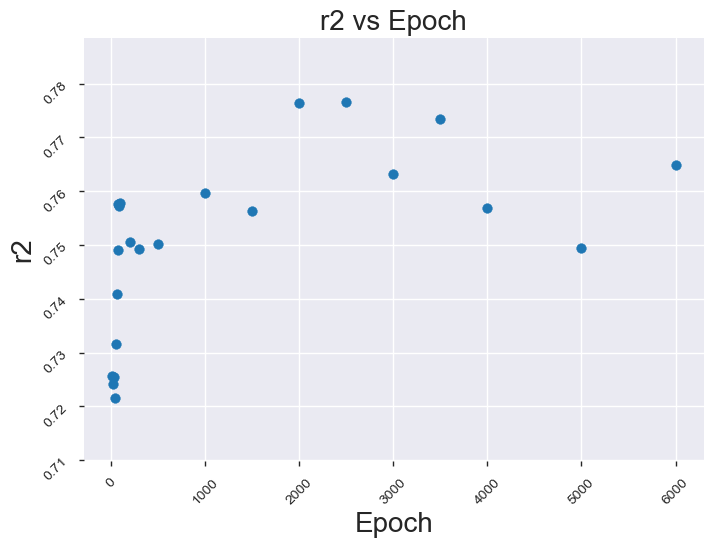

In [65]:
#find the best number of epochs
r2_list = []
rmse_list = []
rmsle_list = []
optimizer = 'nadam'
epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000, 6000]
batch_size = 80
loss = 'mean_squared_error'
metrics = 'mean_squared_error'
for x in epochs:
    y_pred = NN_model_run(optimizer, loss, metrics, x, batch_size)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['epochs','r2', 'RMSE', 'RMSLE'])
resultsdf['epochs'] = epochs
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['epochs'] , y = resultsdf['r2'])
plt.title('r2 vs Epoch', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('Epoch', fontsize =20)

  optimizer        r2          RMSE     RMSLE
0      adam  0.764160  38364.149757  0.154687
1   rmsprop  0.778407  37187.300390  0.154741
2   adagrad  0.750985  39421.180435  0.157175
3  adadelta  0.767554  38087.098575  0.154949
4    adamax  0.756331  38995.748536  0.156268
5     nadam  0.775428  37436.497002  0.154747


Text(0.5,0,'Optimizer Parameters')

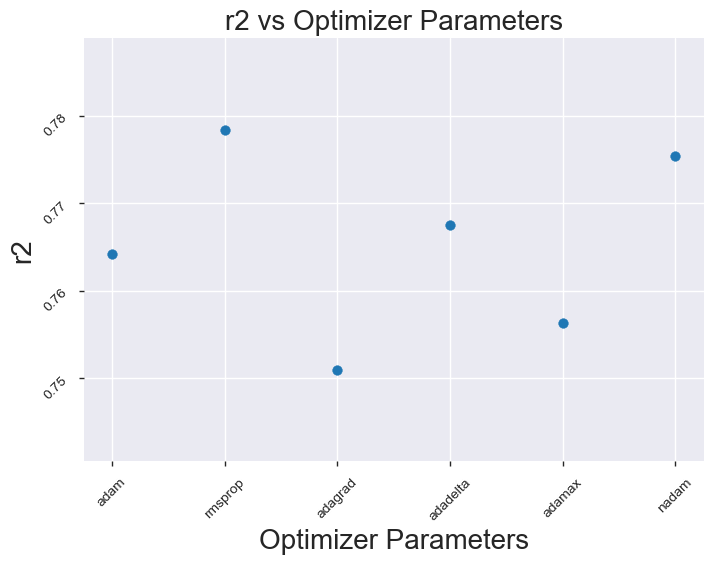

In [66]:


# Find the best optimizer
r2_list = []
rmse_list = []
rmsle_list = []
optimizer = ['adam', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
epochs = 30
batch_size = 80
loss = 'mean_squared_error'
metrics = 'mean_squared_error'
for x in optimizer:
    y_pred = NN_model_run(x, loss, metrics, epochs, batch_size)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['optimizer','r2', 'RMSE', 'RMSLE'])
resultsdf['optimizer'] = optimizer
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['optimizer'] , y = resultsdf['r2'])
plt.title('r2 vs Optimizer Parameters', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('Optimizer Parameters', fontsize =20)

In [ ]:

# Find the best loss
r2_list = []
rmse_list = []
rmsle_list = []
optimizer = 'adam'
epochs = 30
batch_size = 80
loss = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'squared_hinge', 'hinge', 'categorical_hinge', 'logcosh']

metrics = 'mean_squared_error'
for x in loss:
    y_pred = NN_model_run(optimizer, x, metrics, epochs, batch_size)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['loss','r2', 'RMSE', 'RMSLE'])
resultsdf['loss'] = loss
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['loss'] , y = resultsdf['r2'])
plt.title('r2 vs Loss Parameters', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('Loss Parameters', fontsize =20)

#### 6.5.3 Optimized NN Model

r2	0.775
RMSE	37432.434
RMSLE	0.154


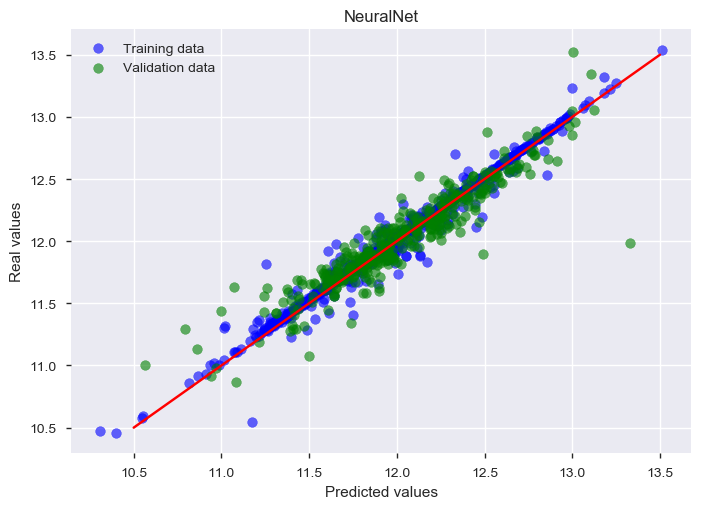

In [68]:
#Now use the best parameters to make the best model
best_NN = NN_model_run('adam', 'mean_squared_error', 'mean_squared_error', 70, 2500)
#convert the prediction back into the same type and shape of the dev labels
def nn_convert(values):   
    values_list = []
    for x in values:
        x = x[0]
        values_list.append(x)
    return values_list

NN_y_pred = nn_convert(best_NN[0])
NN_y_pred_train = nn_convert(best_NN[1])

# eval
score = rmsle(dev_labels, NN_y_pred)
result_scores['Neural Net'] = (score)
    

total_predictions += NN_y_pred
total_pred_count +=1

print("r2\t{:.3f}".format(r2(dev_labels, NN_y_pred)))
print("RMSE\t{:.3f}".format(rmse(dev_labels, NN_y_pred)))
print("RMSLE\t{:.3f}".format(rmsle(dev_labels, NN_y_pred)))

plot_it(NN_y_pred_train, NN_y_pred, 'NeuralNet')

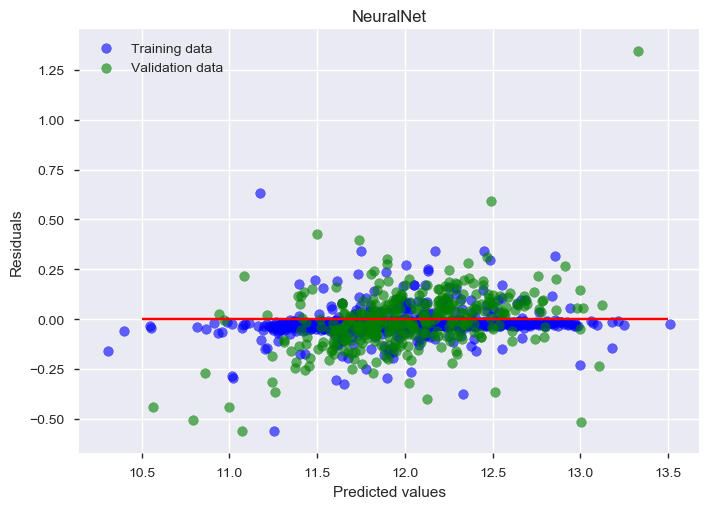

In [69]:
# Plot residuals
plot_residuals(NN_y_pred_train, NN_y_pred, 'NeuralNet')

### 6.6 Decision Tree

In [70]:
# Function to build a decision tree
def decisiontree(max_depth):
    regression1 = DecisionTreeRegressor(max_depth= max_depth)
    regression1.fit(train.values, train_labels)
    reg_predict1 = regression1.predict(dev.values)
    reg_predict1_train = regression1.predict(train.values)
    reg_predict1_key_features = regression1.feature_importances_
    return reg_predict1, reg_predict1_train, reg_predict1_key_features
     
    
# Function to build an Ada Boost Regressor
def adaboostree(max_depth, n_estimators):
    regression2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth= max_depth), n_estimators= n_estimators)
    regression2.fit(train.values, train_labels)
    reg_predict2 = regression2.predict(dev.values)
    reg_predict2_train = regression2.predict(train.values)
    reg_predict2_key_features = regression2.feature_importances_
    return reg_predict2, reg_predict2_train, reg_predict2_key_features
    

#### 6.6.1 Finding optimized Decision Tree Parameters

    max_depth        r2          RMSE     RMSLE
0           2  0.591410  50496.443292  0.236643
1           3  0.707719  42708.771824  0.198149
2           4  0.752626  39291.124839  0.187598
3           5  0.812986  34162.863098  0.174037
4           6  0.784319  36687.902691  0.181595
5           9  0.668246  45501.457465  0.206580
6          10  0.638706  47484.039525  0.203139
7          20  0.686169  44255.282892  0.206849
8          30  0.638048  47527.243268  0.219273
9          40  0.789512  36243.566068  0.208967
10         50  0.797336  35563.618794  0.193897
11        100  0.626015  48310.798461  0.216237
12        200  0.781673  36912.277661  0.202050
13        300  0.646015  47001.256077  0.212385


Text(0.5,0,'max_depth')

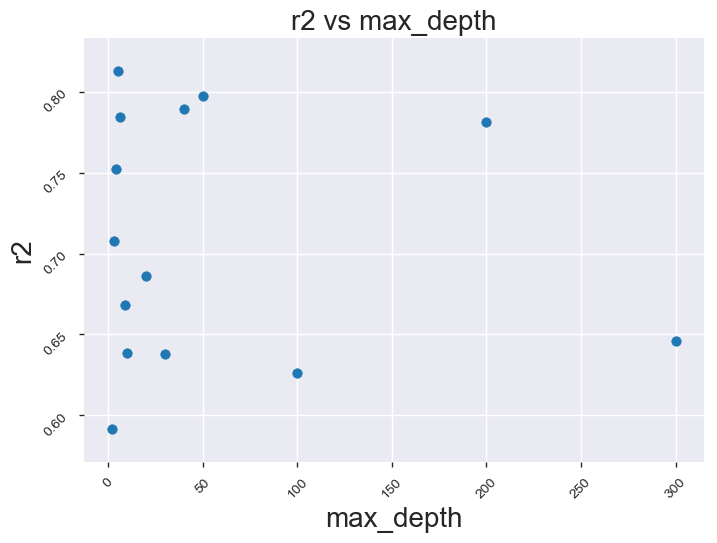

In [71]:
#Find the best max_depth for a Decision Tree
r2_list = []
rmse_list = []
rmsle_list = []
max_depth = [2, 3, 4, 5, 6, 9, 10, 20, 30, 40, 50, 100, 200, 300]
for x in max_depth:
    y_pred = decisiontree(x)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['max_depth','r2', 'RMSE', 'RMSLE'])
resultsdf['max_depth'] = max_depth
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['max_depth'] , y = resultsdf['r2'])
plt.title('r2 vs max_depth', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('max_depth', fontsize =20)

#### 6.6.2 Optimized Decision Tree Model

Decision Tree Model
r2	0.658
RMSE	46197.508
RMSLE	0.215




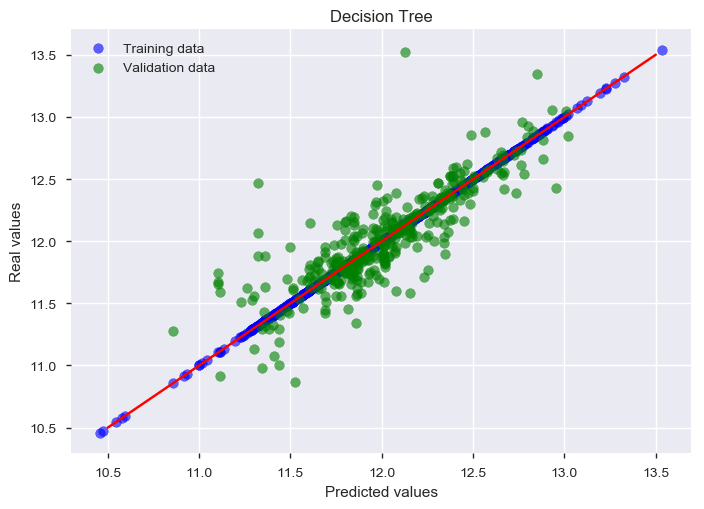

In [72]:
#Add the decision tree with the optimized paramater and add that to our totals
best_decisiontree = decisiontree(20)

total_predictions += best_decisiontree[0]
total_pred_count +=1




# eval

score = rmsle(dev_labels, best_decisiontree[0])
result_scores['Decision Tree'] = (score)

print("Decision Tree Model")
print("r2\t{:.3f}".format(r2(dev_labels, best_decisiontree[0])))
print("RMSE\t{:.3f}".format(rmse(dev_labels, best_decisiontree[0])))
print("RMSLE\t{:.3f}".format(score))
print('\n')
plot_it(best_decisiontree[1], best_decisiontree[0], 'Decision Tree')

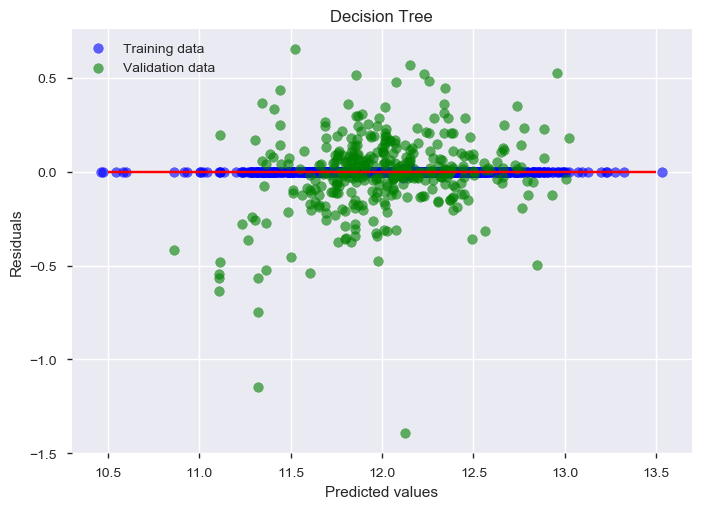

In [73]:
# Plot residuals
plot_residuals(best_decisiontree[1], best_decisiontree[0], 'Decision Tree')

Decision Tree model picked 181 out of 310 features


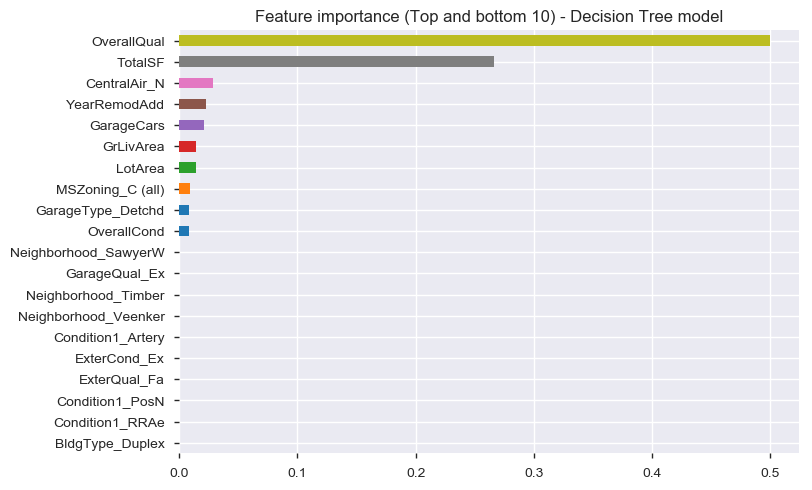

In [74]:
plot_feat_import(best_decisiontree[2], 'Decision Tree')

### 6.6.3 Find Optimized Ada Boost Parameters

    n_estimators        r2          RMSE     RMSLE
0              2  0.722288  41630.768412  0.230029
1              3  0.774410  37521.247835  0.171208
2              4  0.689905  43991.050772  0.183887
3              5  0.768750  37988.983857  0.172450
4              6  0.708699  42637.111598  0.177585
5              9  0.825885  32963.615844  0.153349
6             10  0.732592  40851.189192  0.164433
7             20  0.874475  27988.688265  0.139907
8             30  0.843410  31260.711017  0.138173
9             40  0.843327  31269.054028  0.137509
10            50  0.866479  28866.324138  0.133986
11           100  0.889227  26292.583557  0.133000
12           200  0.855298  30050.658080  0.139948
13           300  0.881749  27165.594774  0.131392


Text(0.5,0,'n_estimators')

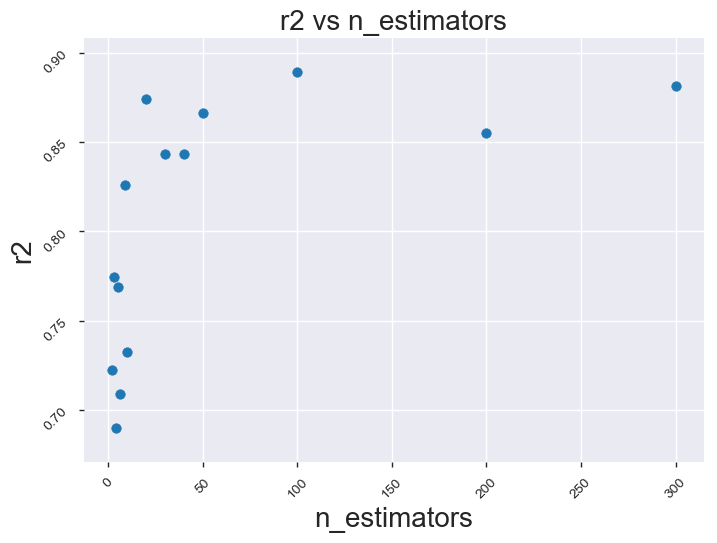

In [75]:
#Find the best number of Ada Boost n_estimators

r2_list = []
rmse_list = []
rmsle_list = []
n_estimators = [2, 3, 4, 5, 6, 9, 10, 20, 30, 40, 50, 100, 200, 300]
for x in n_estimators:
    y_pred = adaboostree(10, x)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['n_estimators','r2', 'RMSE', 'RMSLE'])
resultsdf['n_estimators'] = n_estimators
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['n_estimators'] , y = resultsdf['r2'])
plt.title('r2 vs n_estimators', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('n_estimators', fontsize =20)

    max_depth        r2          RMSE     RMSLE
0           2  0.693513  43734.424317  0.188650
1           3  0.763714  38400.429716  0.180790
2           4  0.756877  38952.069536  0.165763
3           5  0.795161  35753.930304  0.155977
4           6  0.830345  32538.743729  0.152878
5           9  0.882464  27083.305407  0.140713
6          10  0.872824  28172.151886  0.141210
7          20  0.814007  34069.456844  0.152017
8          30  0.892599  25889.387836  0.134627
9          40  0.832229  32357.555658  0.144212
10         50  0.890070  26192.383676  0.135554
11        100  0.861328  29417.863610  0.139428
12        200  0.809913  34442.379472  0.140556
13        300  0.855287  30051.821945  0.141838


Text(0.5,0,'max_depth')

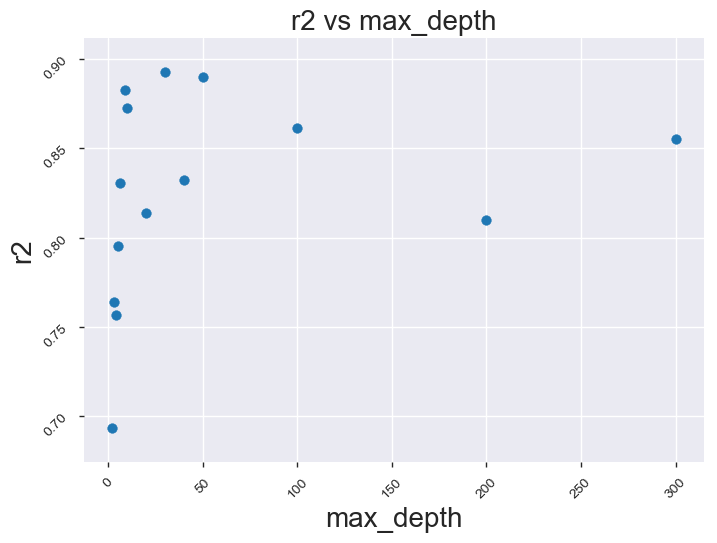

In [76]:

#Find the best max_depth for the Ada Boost Regressor
r2_list = []
rmse_list = []
rmsle_list = []
max_depth = [2, 3, 4, 5, 6, 9, 10, 20, 30, 40, 50, 100, 200, 300]
for x in max_depth:
    y_pred = adaboostree(x, 20)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['max_depth','r2', 'RMSE', 'RMSLE'])
resultsdf['max_depth'] = max_depth
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['max_depth'] , y = resultsdf['r2'])
plt.title('r2 vs max_depth', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('max_depth', fontsize =20)

#### 6.6.4 Optimized Ada Boost Model

Decision Tree Adaboost Model
r2	0.879
RMSE	27476.774
RMSLE	0.132


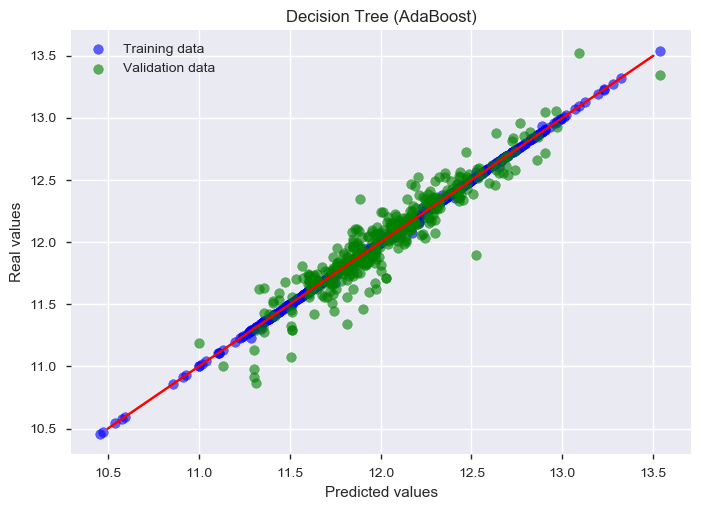

In [77]:
#Add the optimized Ada Boost results to our overall results
# AdaBoost
best_adaboost = adaboostree(100, 20)

# eval
score = rmsle(dev_labels, best_adaboost[0])
result_scores['Decision Tree Adaboost'] = (score)

total_predictions += best_adaboost[0]
total_pred_count +=1

print("Decision Tree Adaboost Model")
print("r2\t{:.3f}".format(r2(dev_labels, best_adaboost[0])))
print("RMSE\t{:.3f}".format(rmse(dev_labels, best_adaboost[0])))
print("RMSLE\t{:.3f}".format(score))
plot_it(best_adaboost[1], best_adaboost[0], 'Decision Tree (AdaBoost)')

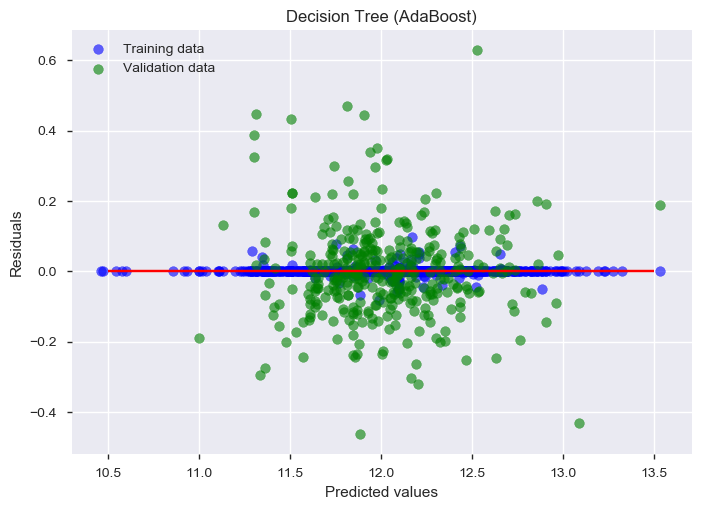

In [78]:
# Plot residuals
plot_residuals(best_adaboost[1], best_adaboost[0], 'Decision Tree (AdaBoost)')

Decision Tree (AdaBoost) model picked 269 out of 310 features


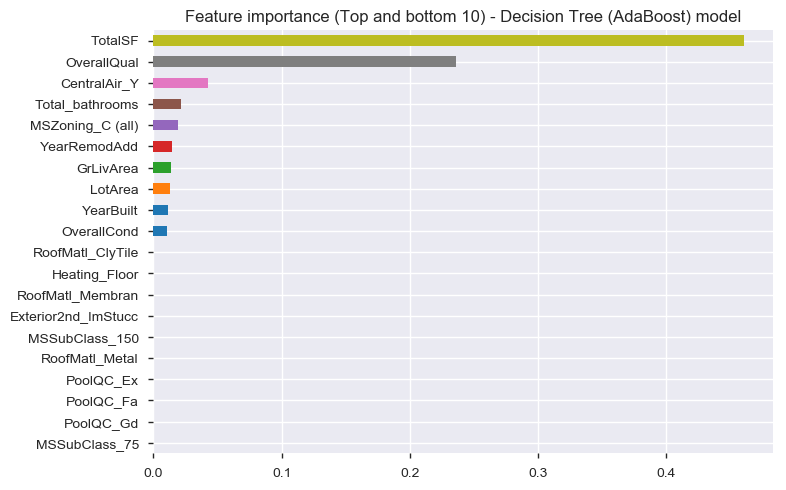

In [79]:

plot_feat_import(best_adaboost[2], 'Decision Tree (AdaBoost)')

#### 6.6.5 Find Optimized Gradient Boosting Regressor Parameters

   n_estimators        r2          RMSE     RMSLE
0            10  0.636168  47650.537000  0.199961
1            25  0.833533  32231.591386  0.142947
2            50  0.855634  30015.804680  0.132967
3            75  0.874060  28034.842312  0.130163
4           100  0.868486  28648.607829  0.129564
5           125  0.860548  29500.543019  0.130283
6           150  0.853254  30262.227300  0.130893
7           175  0.874757  27957.215614  0.129350
8           200  0.871564  28311.302223  0.129229


Text(0.5,0,'n_estimators')

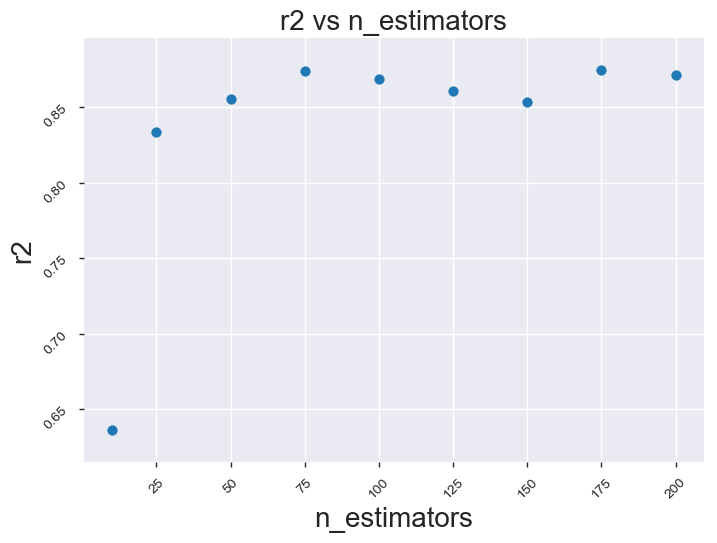

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

#Function to build a Gradient Boost Regressor
def gbr_model(n_estimator, sample_split, depth):
    gbr = GradientBoostingRegressor(n_estimators = n_estimator, min_samples_split = sample_split, max_depth = depth)

    gbr.fit(train.values, train_labels)
    gbr_predict = gbr.predict(dev.values)
    gbr_predict_train = gbr.predict(train.values)
    gbr_predict_key_features = gbr.feature_importances_
    return gbr_predict, gbr_predict_train, gbr_predict_key_features
    
    
#find the best number of n_nestimators   
r2_list = []
rmse_list = []
rmsle_list = []
n_estimators = [10, 25, 50, 75, 100, 125, 150, 175, 200]
for x in n_estimators:
    y_pred = gbr_model(x, 2, 5)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['n_estimators','r2', 'RMSE', 'RMSLE'])
resultsdf['n_estimators'] = n_estimators
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['n_estimators'] , y = resultsdf['r2'])
plt.title('r2 vs n_estimators', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('n_estimators', fontsize =20)

   max_depth        r2          RMSE     RMSLE
0          2  0.868834  28610.662913  0.125816
1          3  0.886587  26604.077849  0.120138
2          4  0.893573  25771.651015  0.118159
3          5  0.856086  29968.789492  0.131506
4          6  0.854509  30132.517374  0.132976
5          9  0.801330  35211.421870  0.148083
6         10  0.802221  35132.346950  0.150151
7         20  0.731766  40914.181015  0.191404
8         50  0.725901  41359.048230  0.191022


Text(0.5,0,'max_depth')

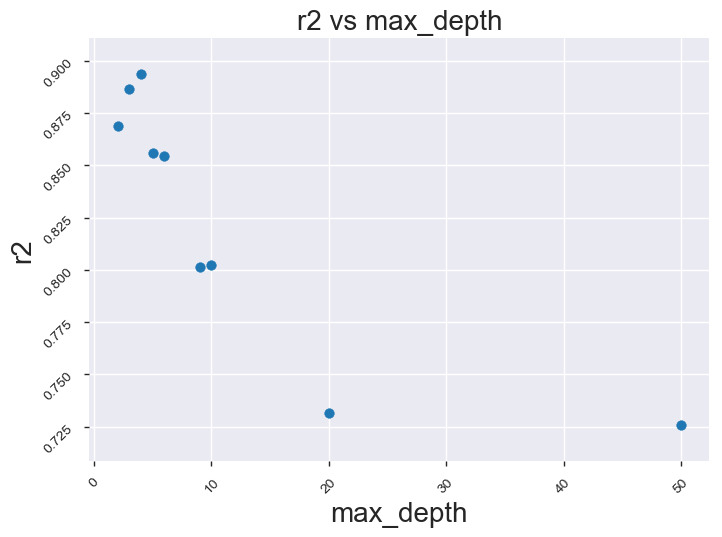

In [81]:
r2_list = []
rmse_list = []
rmsle_list = []
max_depth = [2, 3, 4, 5, 6, 9, 10, 20, 50]
for x in max_depth:
    y_pred = gbr_model(100, 2, x)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['max_depth','r2', 'RMSE', 'RMSLE'])
resultsdf['max_depth'] = max_depth
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['max_depth'] , y = resultsdf['r2'])
plt.title('r2 vs max_depth', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('max_depth', fontsize =20)


    sample_split        r2          RMSE     RMSLE
0              2  0.897366  25308.320060  0.118497
1              3  0.889309  26282.926186  0.118607
2              4  0.891283  26047.434056  0.119549
3              5  0.893196  25817.291005  0.118339
4              6  0.879554  27416.583296  0.119957
5              9  0.892193  25938.257125  0.119795
6             10  0.885951  26678.595668  0.120129
7             20  0.894546  25653.571660  0.118472
8             30  0.893647  25762.736090  0.115392
9             40  0.902467  24671.336970  0.114775
10            50  0.898185  25207.139996  0.116411
11            60  0.890811  26103.993152  0.120385
12            70  0.892644  25883.912046  0.118331
13            80  0.896729  25386.650462  0.120988
14            90  0.897528  25288.281734  0.118881
15           100  0.880934  27259.038239  0.121663
16           200  0.907663  24005.238655  0.119544
17           300  0.892844  25859.865567  0.119339
18           400  0.903351  245

Text(0.5,0,'sample_split')

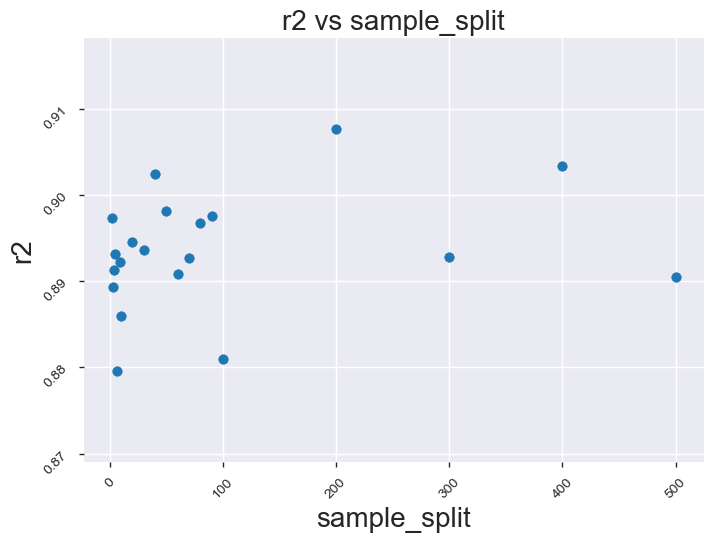

In [82]:
r2_list = []
rmse_list = []
rmsle_list = []
sample_split = [2, 3, 4, 5, 6, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]
for x in sample_split:
    y_pred = gbr_model(100, x, 4)[0]
    r2_list.append(r2(dev_labels, y_pred))
    rmse_list.append(rmse(dev_labels, y_pred))
    rmsle_list.append(rmsle(dev_labels, y_pred))

resultsdf = pd.DataFrame(columns = ['sample_split','r2', 'RMSE', 'RMSLE'])
resultsdf['sample_split'] = sample_split
resultsdf['r2'] = r2_list
resultsdf['RMSE'] = rmse_list
resultsdf['RMSLE'] = rmsle_list
print(resultsdf)
plt.scatter(x = resultsdf['sample_split'] , y = resultsdf['r2'])
plt.title('r2 vs sample_split', fontsize =20)
plt.tick_params(labelrotation = 45)
plt.ylabel('r2', fontsize =20)
plt.xlabel('sample_split', fontsize =20)

#### 6.6.6 Optimized Gradient Boosting Regressor Model

Gradient Boost Regressor Model
r2	0.908
RMSE	24005.239
RMSLE	0.120


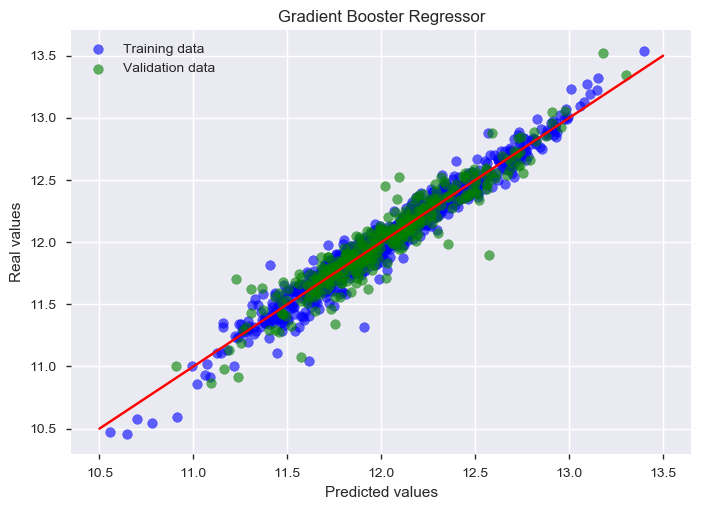

In [83]:
#Best Gradient Boost Regression
best_gbr_predict = gbr_model(100, 200, 4)


total_predictions += best_gbr_predict[0]
total_pred_count +=1

# eval
score = rmsle(dev_labels, best_gbr_predict[0])
result_scores['Gradient Booster Regressor'] = (score)

print("Gradient Boost Regressor Model")
print("r2\t{:.3f}".format(r2(dev_labels, best_gbr_predict[0])))
print("RMSE\t{:.3f}".format(rmse(dev_labels, best_gbr_predict[0])))
print("RMSLE\t{:.3f}".format(score))

plot_it(best_gbr_predict[1], best_gbr_predict[0], 'Gradient Booster Regressor')

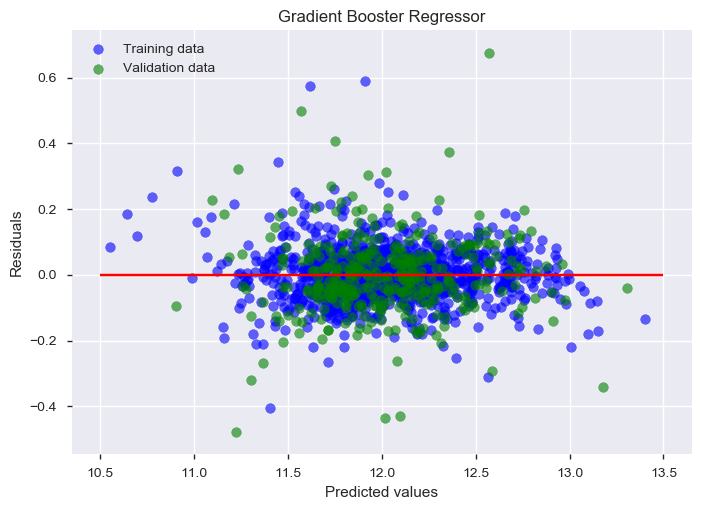

In [84]:
plot_residuals(best_gbr_predict[1], best_gbr_predict[0], 'Gradient Booster Regressor')

Gradient Booster Regressor model picked 94 out of 310 features


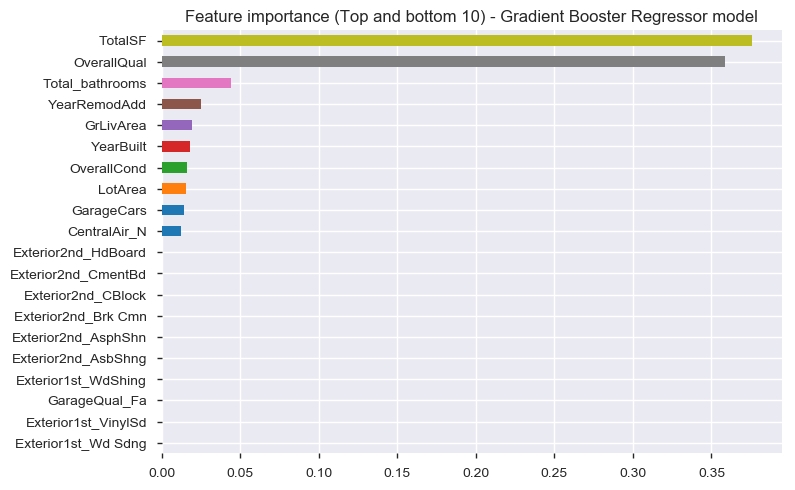

In [85]:
plot_feat_import(best_gbr_predict[2], 'Gradient Booster Regressor')

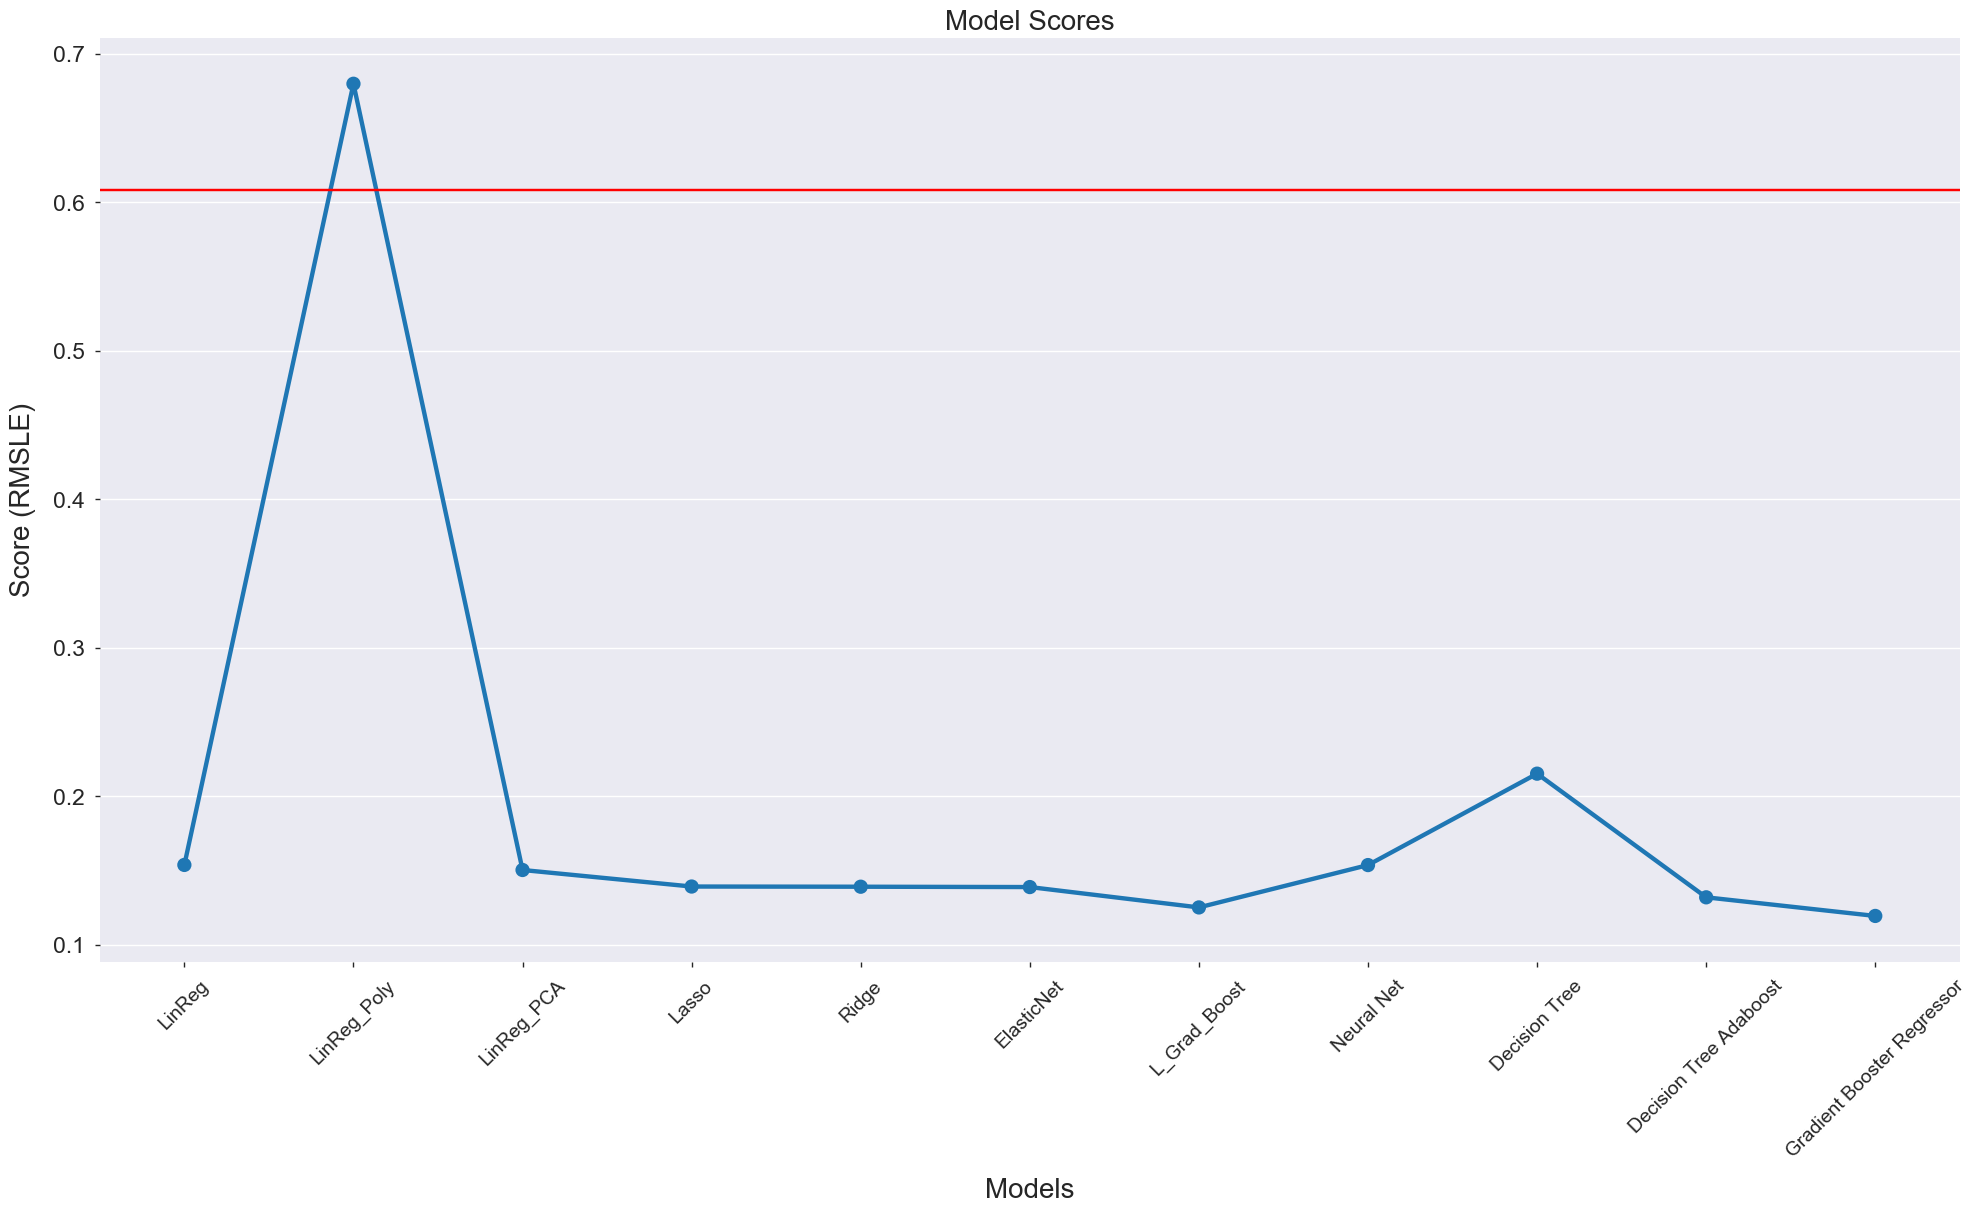

In [99]:
# Plot the predictions for each model
fig = plt.figure(figsize=(24, 12))
ax = sns.pointplot(x=list(result_scores.keys()), y=list(result_scores.values()), markers=['o'], linestyles=['-'])
#for i, score in enumerate(result_scores.values()):
    #ax.text(score[0], '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black')
    
plt.axhline(y=0.608, color='r', linestyle='-')
plt.ylabel('Score (RMSLE)', size=20, labelpad=12.5)
plt.xlabel('Models', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=14, labelrotation = 45)
plt.tick_params(axis='y', labelsize=16.5)
plt.title('Model Scores', size=20)

plt.show()

In [87]:
result_scores

{'LinReg': 0.15388519734523318,
 'LinReg_Poly': 0.6796945686477764,
 'LinReg_PCA': 0.15047140056480593,
 'Lasso': 0.1393399933974815,
 'Ridge': 0.13921652234660561,
 'ElasticNet': 0.13898584901490066,
 'L_Grad_Boost': 0.125277903652097,
 'Neural Net': 0.15378661853320913,
 'Decision Tree': 0.21530947951805005,
 'Decision Tree Adaboost': 0.13207992418547004,
 'Gradient Booster Regressor': 0.11954408527193157}

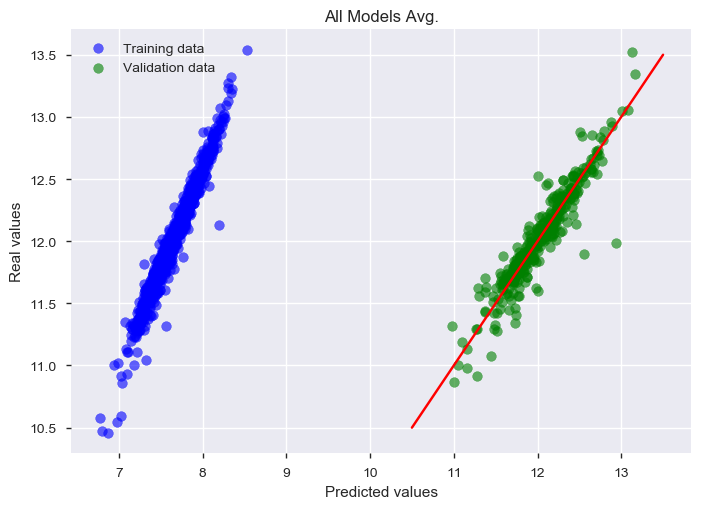

In [88]:
accum_predictions = total_predictions/total_pred_count

accum_pred_train = Total_pred_train/total_pred_count


plot_it(accum_pred_train, accum_predictions, 'All Models Avg.')


#References:
Extensive use of internet resources to infer thinking, further context can be provided if needed.
https://scikit-learn.org - used for NN, Decision Trees
https://pandas.pydata.org - used for many pandas references
stackoverflow.com
https://www.kaggle.com/randomjosh/w207-finalproject-jkc-v2
Extensive use referenced in NN development
#https://keras.io/
#https://www.kaggle.com/gopeshk/eda-and-prediction#Model-Training
#https://medium.com/intuitive-deep-learning/build-your-first-neural-network-to-predict-house-prices-with-keras-eb5db60232c
#https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-80.php
https://hackernoon.com/build-your-first-neural-network-to-predict-house-prices-with-keras-3fb0839680f4
